In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

Loading the data from the csv file (generated using antimony script)

In [6]:
loadedArr = np.loadtxt('drive/My Drive/Colab Notebooks/S_1_point_1.csv')
loadedOriginal = loadedArr.reshape(loadedArr.shape[0], loadedArr.shape[1] // 10, 10)
a = loadedOriginal
simulations = a.shape[0]
timesteps = a.shape[1]
dimensions = a.shape[2]
print("simulations * timesteps * dimensions")
print(a.shape)

simulations * timesteps * dimensions
(10000, 99, 10)


In [7]:
no_of_sims_for_testing = 100
print('Total number of datapoints for test data')
print(timesteps*no_of_sims_for_testing)

Total number of datapoints for test data
9900


In [8]:
a_test = a[:no_of_sims_for_testing]
a_train = a[no_of_sims_for_testing:]

**Preparing the data. Using only the dynamic variables and not parameter values**

In [9]:
batches_of_TrainX = []
for i in range(a_train.shape[0]):
        data = {
        'time_steps' : a_train[i,:,0], 
        '[T]' : a_train[i,:,1], 
        '[I]' : a_train[i,:,2],
        '[V]' : a_train[i,:,3],
        '[J]' : a_train[i,:,4] ,
        #'beta' : a_train[i,:,5], 
        #'k' : a_train[i,:,6],
        #'p' : a_train[i,:,7],
        #'b' : a_train[i,:,8],
        #'c' : a_train[i,:,9] 
               }
        data = pd.DataFrame(data) 
        batches_of_TrainX.append(data)

batches_of_TrainX[100][1:20]

,time_steps,[T],[I],[V],[J]
1,0.202020,3.999817e+08,1.587192e+04,8.772000e+00,2.074181e+03
2,0.303030,3.996537e+08,3.007039e+05,1.662332e+02,3.930471e+04
3,0.404040,3.934969e+08,5.643890e+06,3.141818e+03,7.410776e+05
4,0.505051,2.955663e+08,8.953383e+07,5.650539e+04,1.276528e+07
5,0.606061,6.674668e+06,2.827218e+08,5.818083e+05,8.746452e+07
6,0.707071,2.168708e-01,1.855362e+08,1.680200e+06,1.363472e+08
7,0.808081,1.420261e-13,1.188262e+08,2.519645e+06,1.377650e+08
8,0.909091,-9.143842e-13,7.610196e+07,2.868036e+06,1.198259e+08
9,1.010101,6.706688e-13,4.873931e+07,2.818747e+06,9.653168e+07
10,1.111111,-9.142073e-13,3.121493e+07,2.530293e+06,7.421888e+07


In [10]:
batches_of_TrainX = np.array(batches_of_TrainX)
batches_of_TrainX.shape

(9900, 99, 5)

**This line can be tweaked for predicting other variables**



In [11]:
dimension_to_predict = 1

Scaling the data

In [12]:
from sklearn.compose import ColumnTransformer
import sklearn
scaled_batches = batches_of_TrainX.reshape(batches_of_TrainX.shape[0]*batches_of_TrainX.shape[1],batches_of_TrainX.shape[2])
#scaler_choice = sklearn.preprocessing.MinMaxScaler()
scaler_1 = sklearn.preprocessing.MinMaxScaler()
scaler_1 = scaler_1.fit(scaled_batches)
scaler_2 = sklearn.preprocessing.MinMaxScaler()
scaler_2 = scaler_2.fit(scaled_batches[:,dimension_to_predict].reshape(-1,1))

scalar_3 = sklearn.preprocessing.MinMaxScaler()
scaler_3 = scaler_1.fit(scaled_batches[:,:5])

scaled_batches = scaler_1.transform(scaled_batches)

In [13]:
trainX = []
for i in range(batches_of_TrainX.shape[0]):
    trainX.append(scaled_batches[i*batches_of_TrainX.shape[1]:(i+1)*batches_of_TrainX.shape[1]])  
trainX = np.array(trainX)
trainX.shape

(9900, 99, 5)

In [14]:
batches_of_TrainX_array = trainX

**Time windowing**

In [15]:
TrainX = []
TrainY = []
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3  # Number of past days we want to use to predict the future.
window_end_number = timesteps - n_past



for i in range(batches_of_TrainX_array.shape[0]):
    train_batch = []
    train_tempY = []
    for j in range(n_past, batches_of_TrainX_array.shape[1] - n_future +1):
        train_batch.append(batches_of_TrainX_array[i,j-n_past:j,:])
        train_tempY.append(batches_of_TrainX_array[i, j+n_future-1 : j+n_future , dimension_to_predict])
        
    TrainX.append(train_batch)
    TrainY.append(train_tempY)

    
TrainX = np.array(TrainX)
TrainY = np.array(TrainY)
print('TrainX shape == {}.'.format(TrainX.shape))
print('TrainY shape == {}.'.format(TrainY.shape))

TrainX shape == (9900, 96, 3, 5).
TrainY shape == (9900, 96, 1).


***Defining the model***

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipvalue=0.5)
model = Sequential()
model.add(LSTM(32, batch_input_shape=(TrainX.shape[1],TrainX.shape[2], TrainX.shape[3]), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(TrainY.shape[2]))
model.compile(optimizer='Adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (96, 3, 32)               4864      
                                                                 
 lstm_1 (LSTM)               (96, 3, 64)               24832     
                                                                 
 lstm_2 (LSTM)               (96, 3, 128)              98816     
                                                                 
 dropout (Dropout)           (96, 3, 128)              0         
                                                                 
 lstm_3 (LSTM)               (96, 32)                  20608     
                                                                 
 dropout_1 (Dropout)         (96, 32)                  0         
                                                                 
 dense (Dense)               (96, 1)                   3

**Training the model**

In [16]:
TrainX = TrainX.reshape(TrainX.shape[0]*TrainX.shape[1],TrainX.shape[2],TrainX.shape[3])
TrainY = TrainY.reshape(TrainY.shape[0]*TrainY.shape[1],TrainY.shape[2])
history = model.fit(TrainX, TrainY, epochs=15, batch_size=window_end_number, validation_split=0.05, verbose=1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

Epoch 1/15
9405/9405 [==============================] - 75s 7ms/step - loss: 6.3967e-04 - val_loss: 1.0055e-05
Epoch 2/15
3990/9405 [===========>..................] - ETA: 34s - loss: 6.3811e-04

KeyboardInterrupt: ignored

In [ ]:
model.save('drive/My Drive/Colab Notebooks/pred_t_1000')

INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/pred_t_1000/assets


INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/pred_t_1000/assets


In [3]:
model = tf.keras.models.load_model('drive/My Drive/Colab Notebooks/pred_t_1000')

**Preparing the test_data**

In [66]:
batches_of_TestX = []
for i in range(a_test.shape[0]):
        data = {
        'time_steps' : a_test[i,:,0], 
        '[T]' : a_test[i,:,1], 
        '[I]' : a_test[i,:,2],
        '[V]' : a_test[i,:,3],
        '[J]' : a_test[i,:,4] ,
        #'beta' : a_test[i,:,5], 
        #'k' : a_test[i,:,6],
        #'p' : a_test[i,:,7],
        #'b' : a_test[i,:,8],
        #'c' : a_test[i,:,9] 
               }
        data = pd.DataFrame(data) 
        batches_of_TestX.append(data)

batches_of_TestX[5][:99]

,time_steps,[T],[I],[V],[J]
0,0.101010,3.999998e+08,127.155091,0.049522,22.235071
1,0.202020,3.999997e+08,250.786787,0.099086,69.540555
2,0.303030,3.999992e+08,550.140542,0.234734,162.037329
3,0.404040,3.999982e+08,1255.894576,0.540571,369.641766
4,0.505051,3.999959e+08,2874.452594,1.236756,844.981036
...,...,...,...,...,...
94,9.595960,2.155506e-02,0.001745,0.000250,0.050198
95,9.696970,2.155506e-02,0.001238,0.000180,0.036128
96,9.797980,2.155506e-02,0.000878,0.000130,0.025997
97,9.898990,2.155506e-02,0.000623,0.000093,0.018704


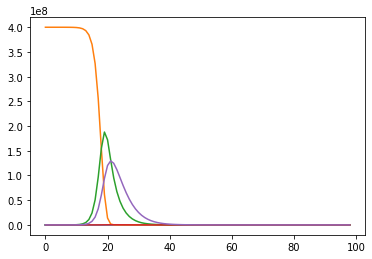

In [67]:
plt.plot(batches_of_TestX[5][:99])

In [68]:
batches_of_TestX = np.array(batches_of_TestX)
batches_of_TestX.shape

(100, 99, 5)

In [69]:
scaled_batches_1 = batches_of_TestX.reshape(batches_of_TestX.shape[0]*batches_of_TestX.shape[1],batches_of_TestX.shape[2])
#scaler_2 = StandardScaler()
#scaler_3 = StandardScaler()
#scaler_3 = scaler_3.fit(scaled_batches_1)
#scaler_2 = scaler_2.fit(scaled_batches_1[:,3].reshape(-1,1))
scaled_batches_1 = scaler_1.transform(scaled_batches_1)
scaled_batches_1.shape
# scale v here if you want to do something with it

(9900, 5)

In [70]:
testX = []
for i in range(batches_of_TestX.shape[0]):
    testX.append(scaled_batches[i*batches_of_TestX.shape[1]:(i+1)*batches_of_TestX.shape[1]])  
testX = np.array(testX)
testX.shape

(100, 99, 5)

In [71]:
TestX = []
for i in range(testX.shape[0]):
    test_batch = []
    for j in range(n_past, testX.shape[1] - n_future +1):
        test_batch.append(testX[i,j-n_past:j,:])
    TestX.append(test_batch)
TestX = np.array(TestX)
TestX.shape

(100, 96, 3, 5)

In [72]:
TestX = []
for i in range(testX.shape[0]):
    test_batch = []
    for j in range(n_past, testX.shape[1] - n_future +1):
        test_batch.append(testX[i,j-n_past:j,:])
    TestX.append(test_batch)
TestX = np.array(TestX)
TestX.shape

(100, 96, 3, 5)

In [73]:
TestX = TestX.reshape(TestX.shape[0]*TestX.shape[1],TestX.shape[2],TestX.shape[3])
Y_pred_V = model.predict(TestX,batch_size=window_end_number)
Y_pred_V = Y_pred_V.reshape(-1)
Y_pred_V[0:125]

array([0.9825577 , 0.97366697, 0.8171123 , 0.2529908 , 0.00563215,
       0.00173418, 0.0032423 , 0.00243069, 0.00256874, 0.00265786,
       0.00273038, 0.00284695, 0.00297567, 0.00301815, 0.00295588,
       0.00283002, 0.00268971, 0.00257363, 0.00249663, 0.00245266,
       0.00242865, 0.00241388, 0.00240237, 0.0023915 , 0.00238067,
       0.00236998, 0.00235979, 0.00235046, 0.00234225, 0.0023353 ,
       0.00232964, 0.0023253 , 0.0023222 , 0.00232019, 0.00231917,
       0.002319  , 0.00231951, 0.00232052, 0.00232192, 0.0023235 ,
       0.00232512, 0.00232665, 0.00232792, 0.0023288 , 0.00232919,
       0.00232895, 0.00232797, 0.00232616, 0.00232346, 0.00231976,
       0.00231501, 0.0023092 , 0.00230221, 0.00229407, 0.00228475,
       0.0022742 , 0.00226247, 0.00224955, 0.00223548, 0.00222027,
       0.00220394, 0.00218657, 0.00216819, 0.00214887, 0.00212871,
       0.00210775, 0.00208609, 0.00206378, 0.00204096, 0.00201772,
       0.00199416, 0.00197037, 0.00194647, 0.0019226 , 0.00189

In [74]:
Y_pred_V_scaled_back = scaler_2.inverse_transform(Y_pred_V.reshape(-1,1))
#Y_pred_V_scaled_back[0:100]

In [75]:
fin_values = []
for i in range(100):
    fin_values.append(Y_pred_V_scaled_back[i*window_end_number:(i+1)*window_end_number])  
fin_values = np.array(fin_values)
fin_values = fin_values.reshape(100,window_end_number)
fin_values.shape

(100, 96)

In [76]:
original_vals = a_test[:,:,:]
original_vals.shape
original_vals = original_vals[:,timesteps-window_end_number:,1]
original_vals.shape

both_together = np.empty()
#stop here

(100, 96)

**Plotting the real and predicted values of "T"**

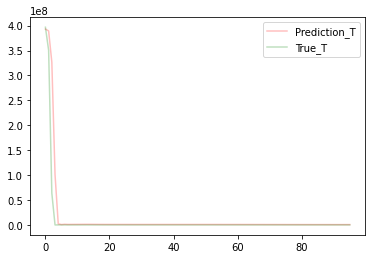

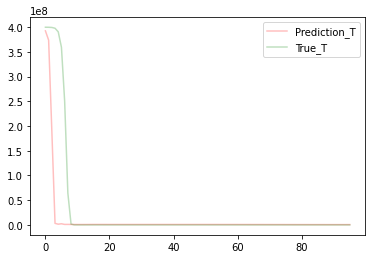

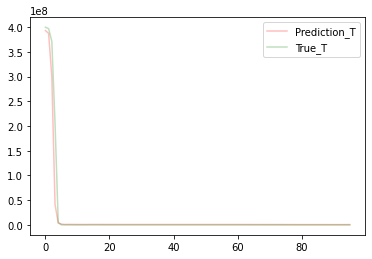

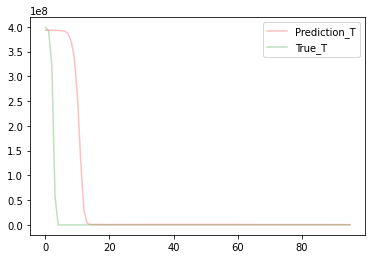

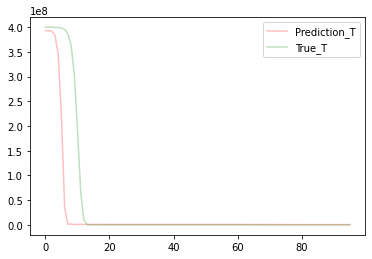

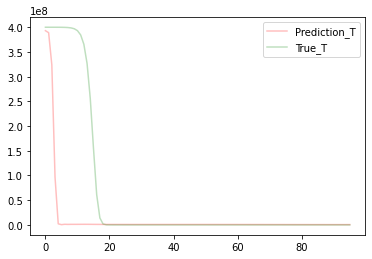

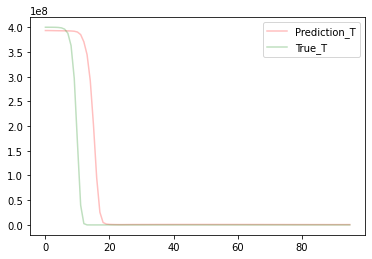

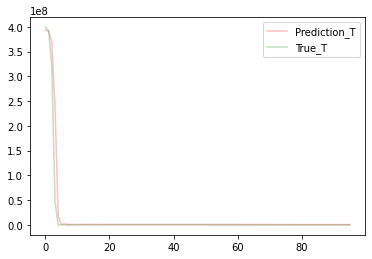

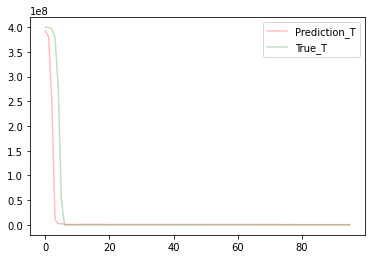

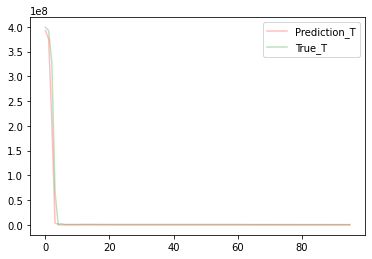

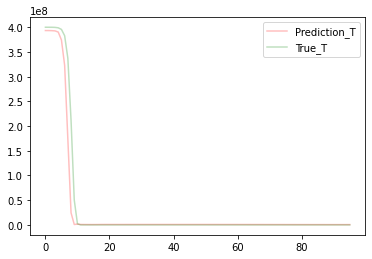

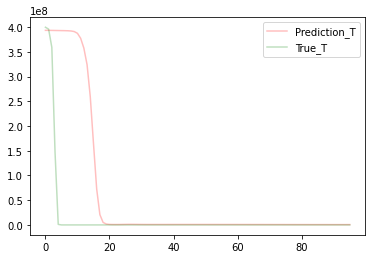

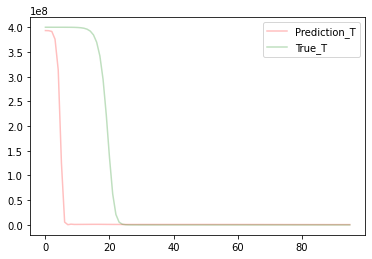

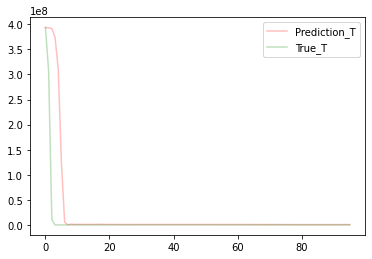

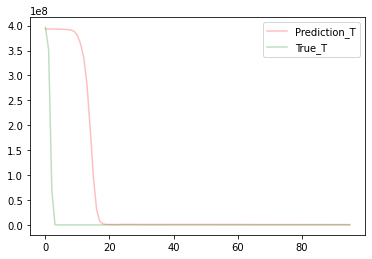

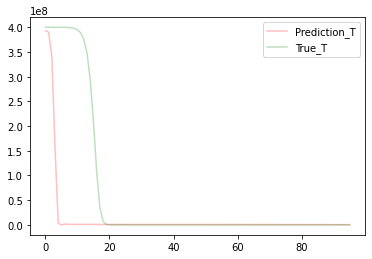

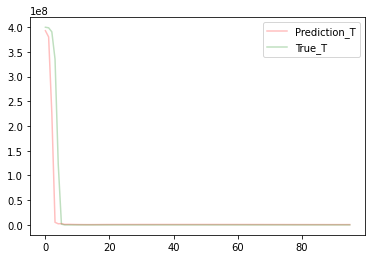

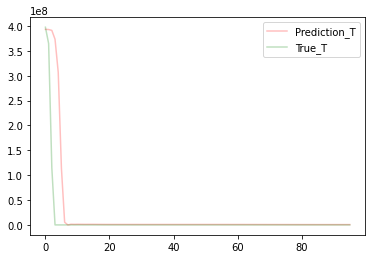

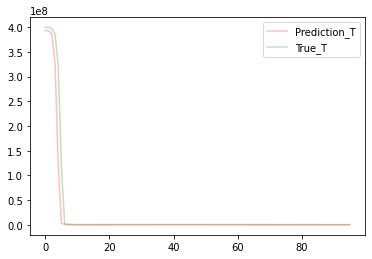

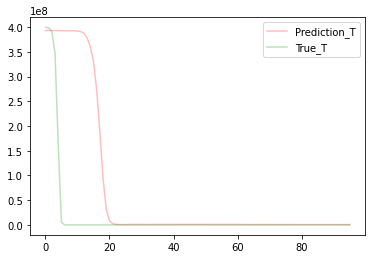

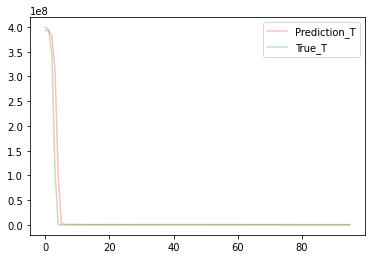

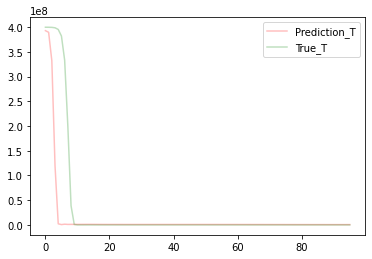

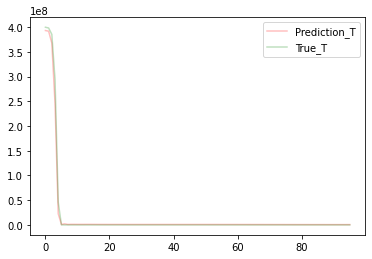

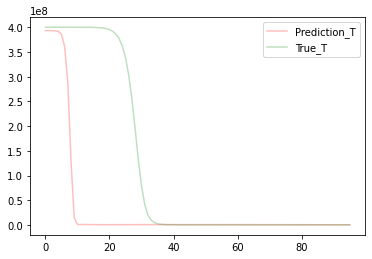

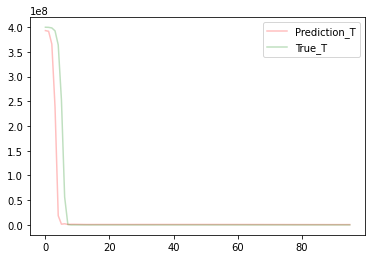

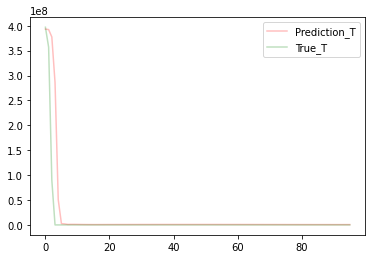

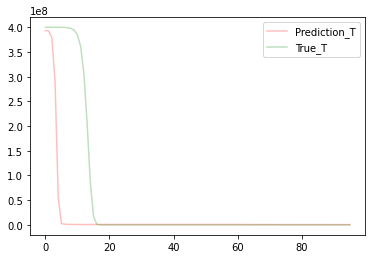

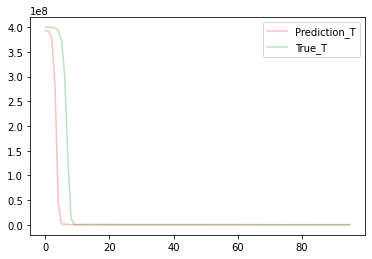

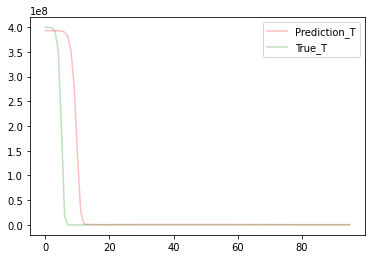

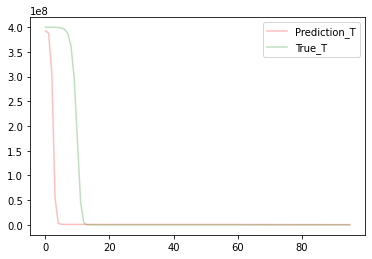

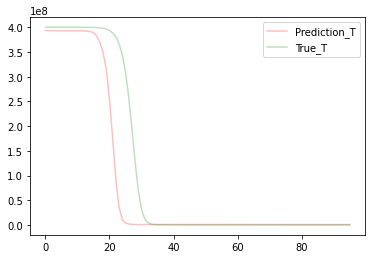

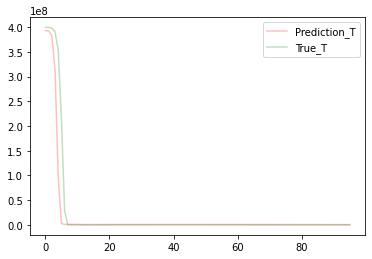

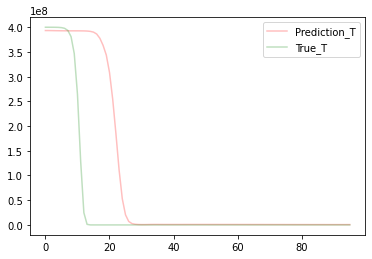

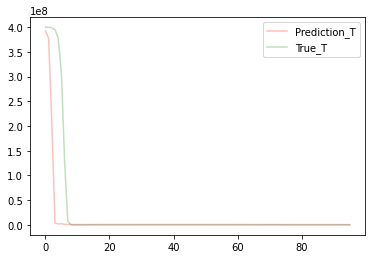

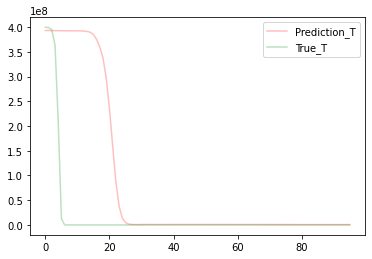

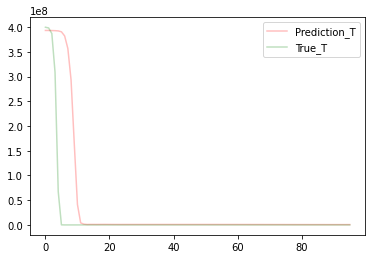

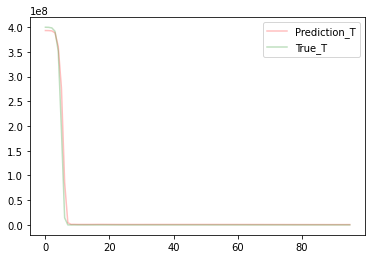

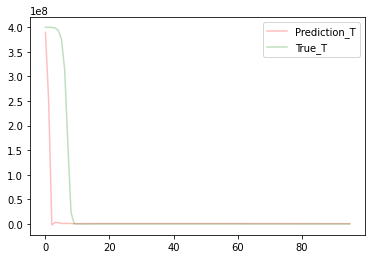

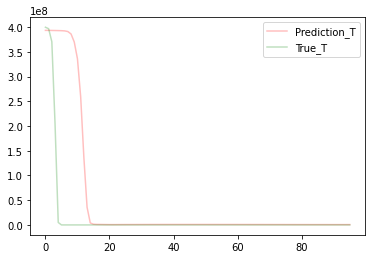

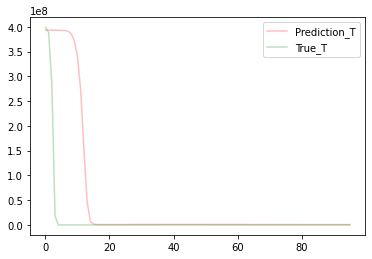

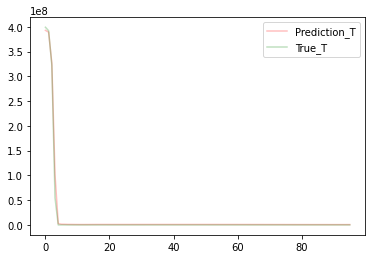

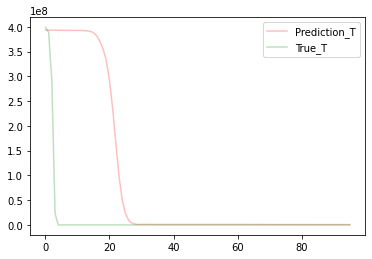

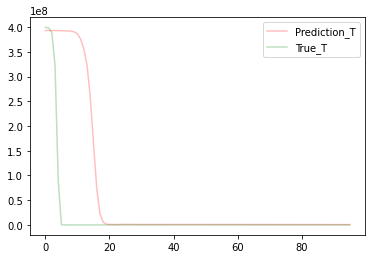

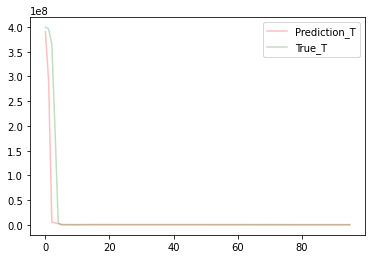

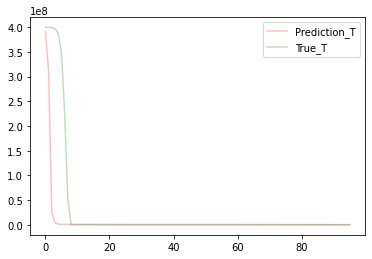

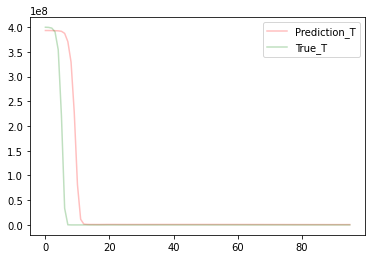

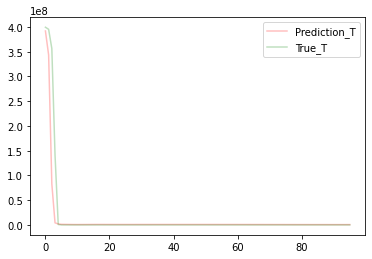

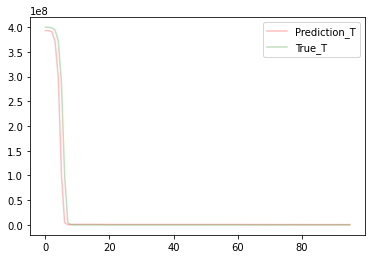

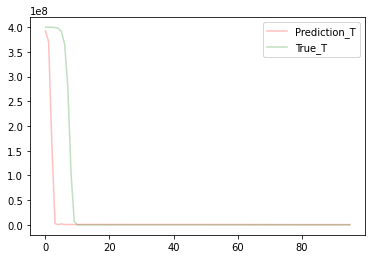

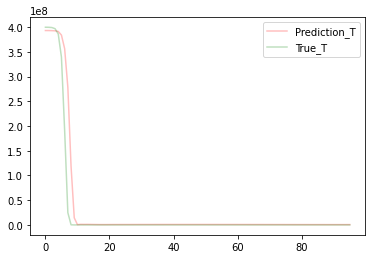

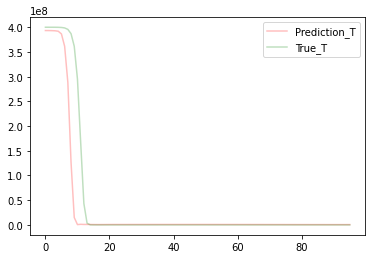

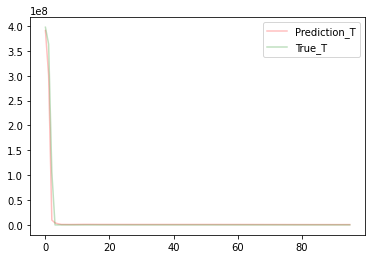

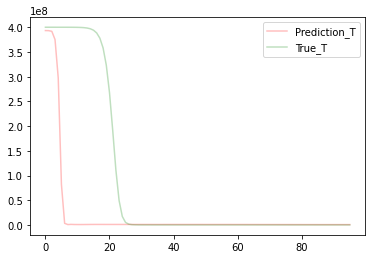

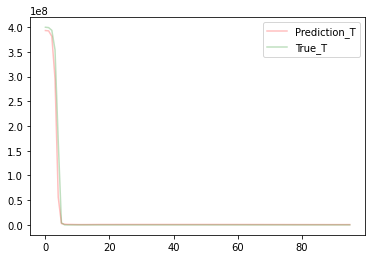

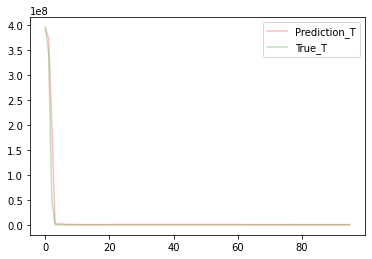

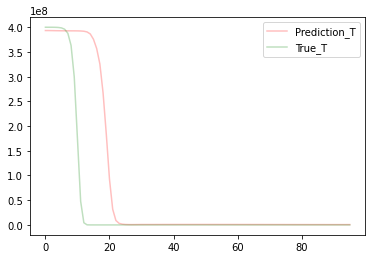

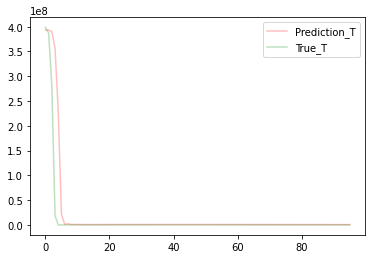

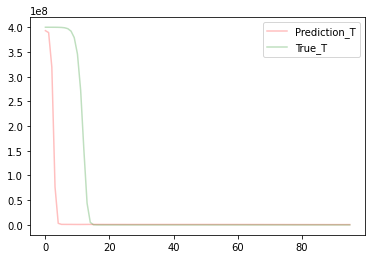

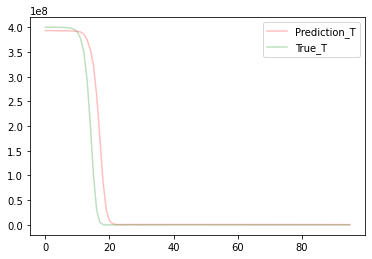

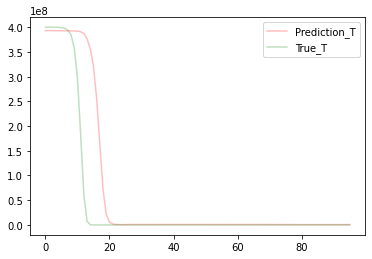

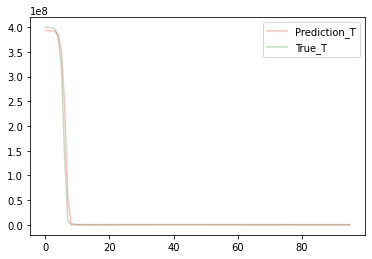

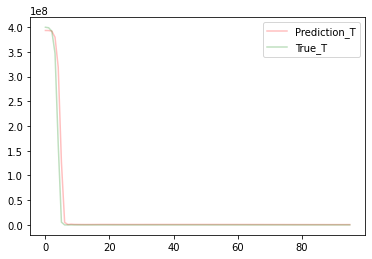

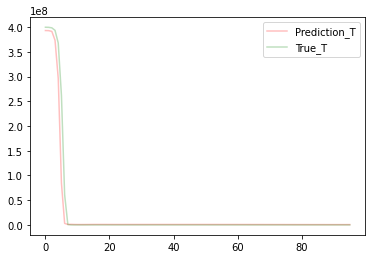

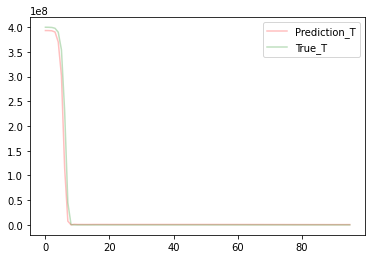

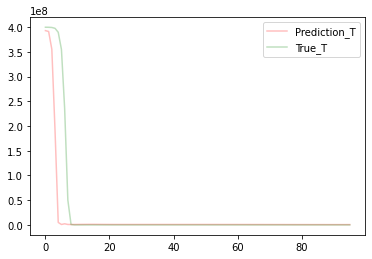

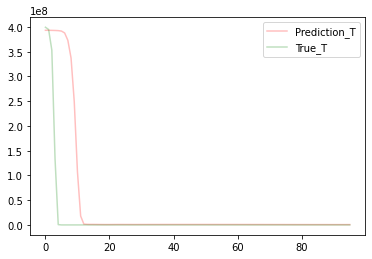

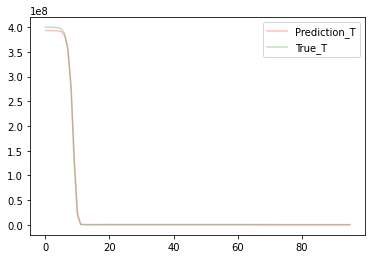

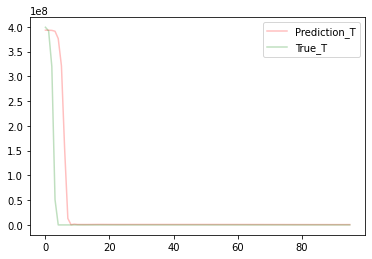

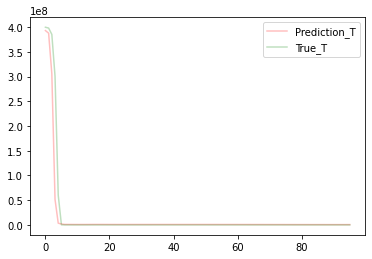

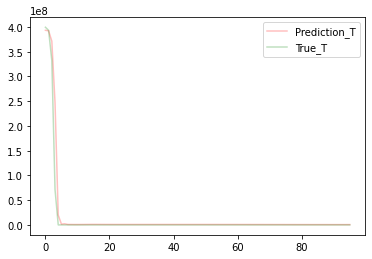

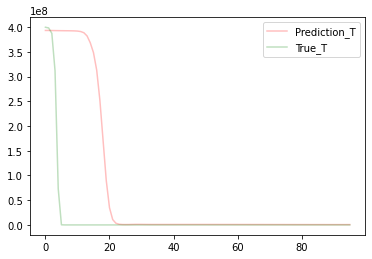

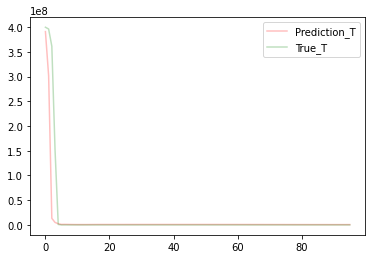

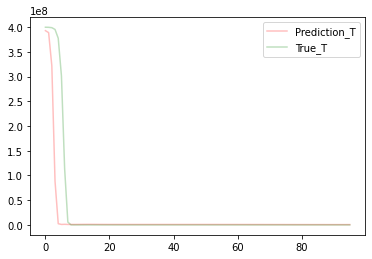

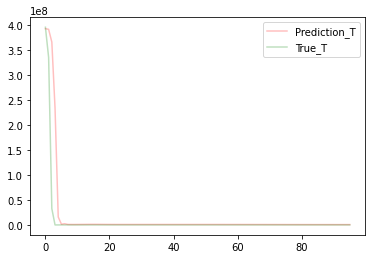

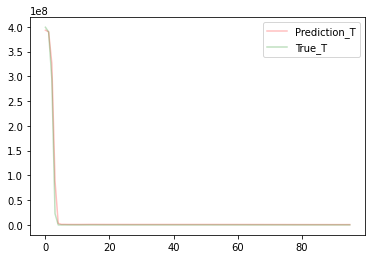

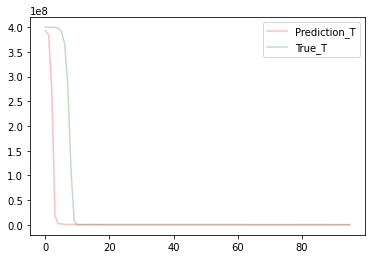

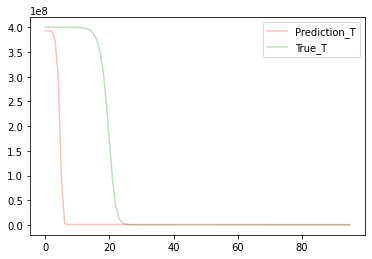

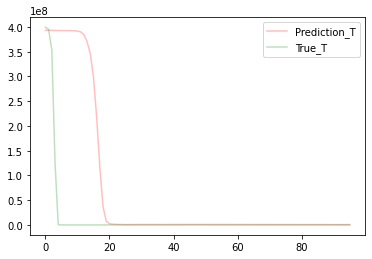

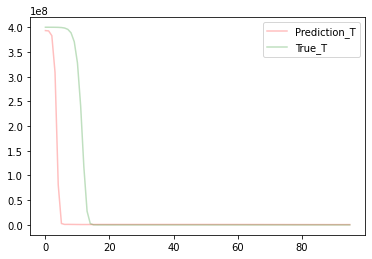

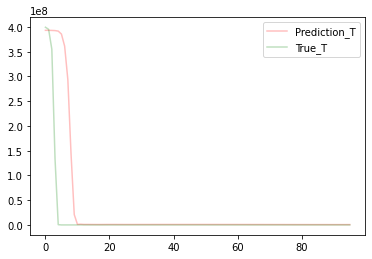

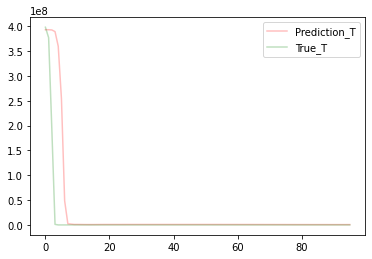

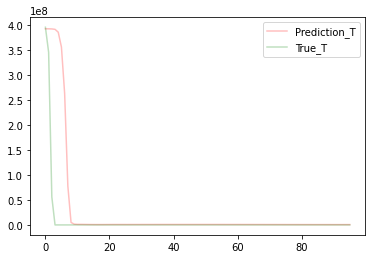

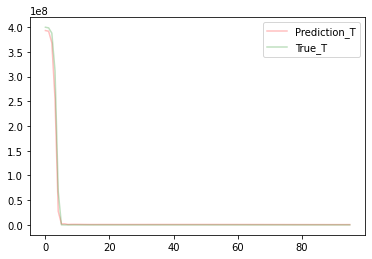

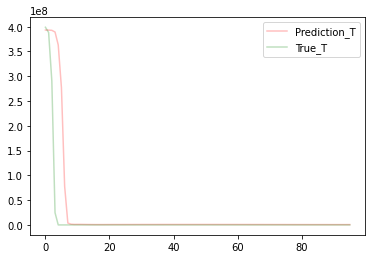

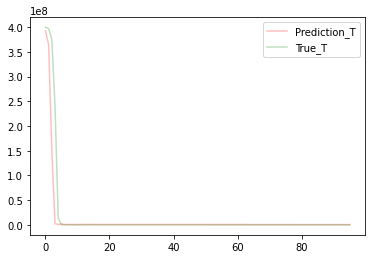

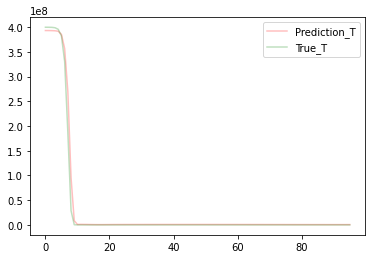

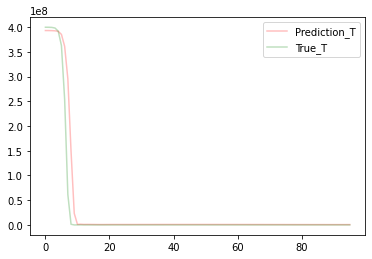

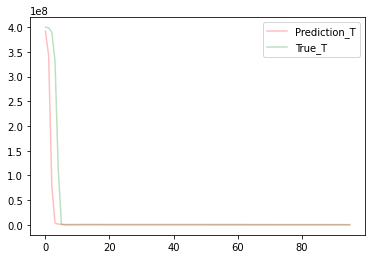

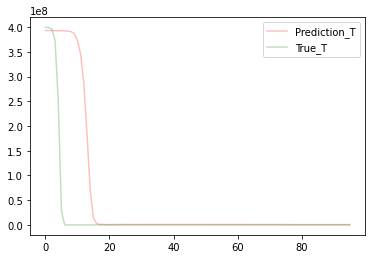

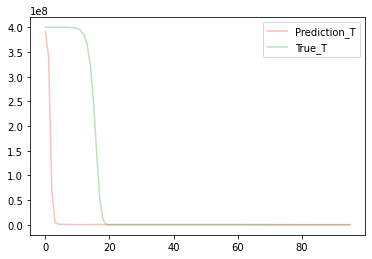

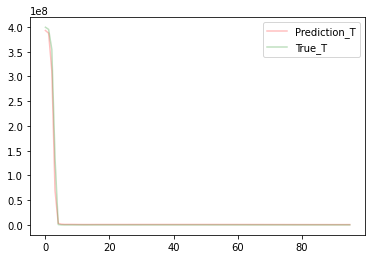

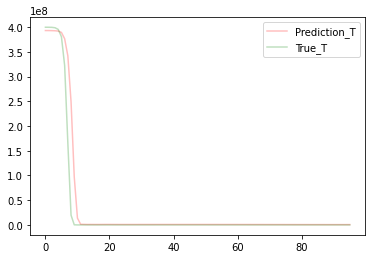

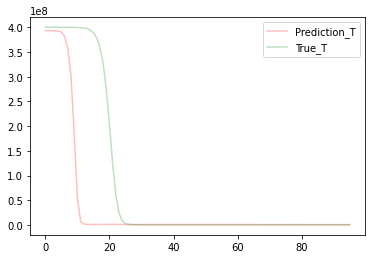

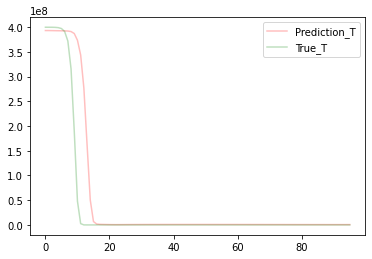

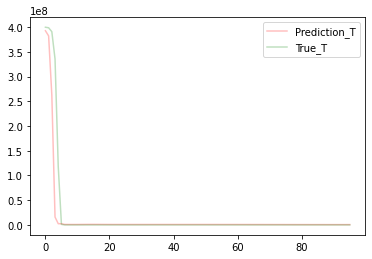

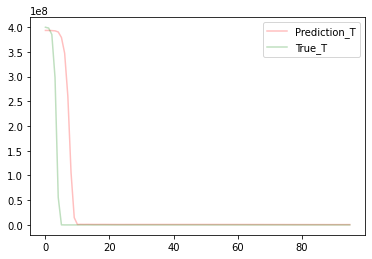

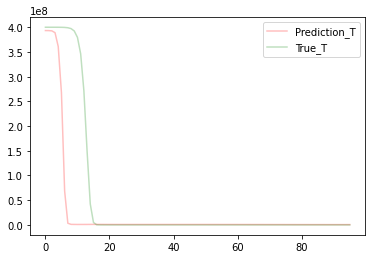

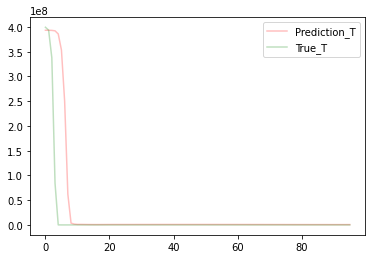

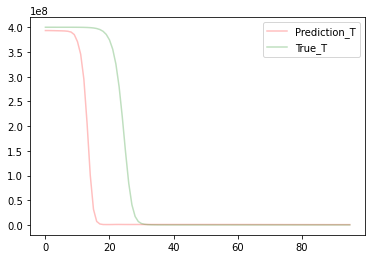

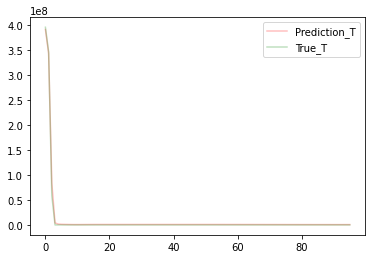

In [65]:
overlapping = 0.25
for x in range(100):
    plt.plot(fin_values[x],c='red', alpha=overlapping,label='Prediction_T')
    plt.plot(original_vals[x],c='green', alpha=overlapping,label='True_T')

    plt.legend()
    plt.show()

The following plots were not successfully drawn because of a scaling error. Will update a new document as soon as the bug is resolved:

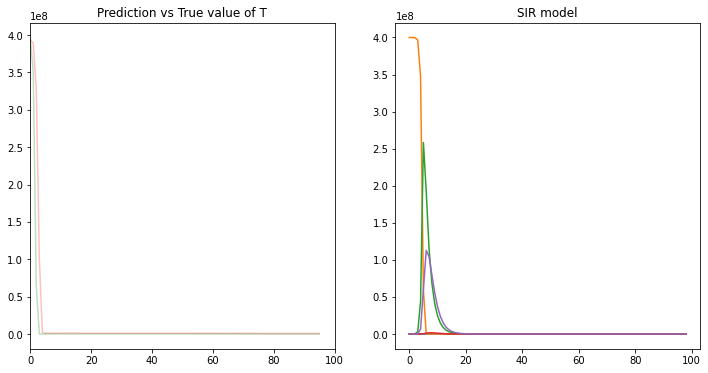

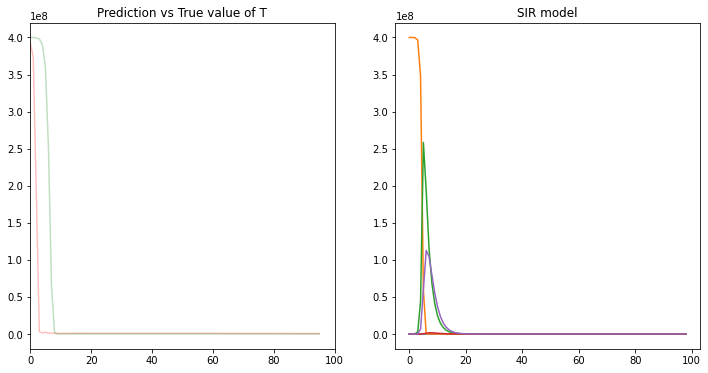

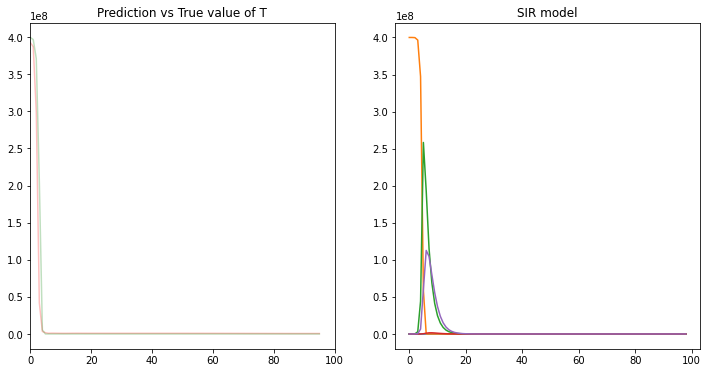

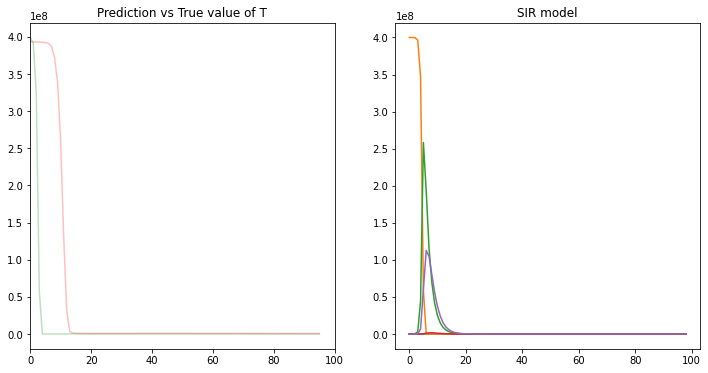

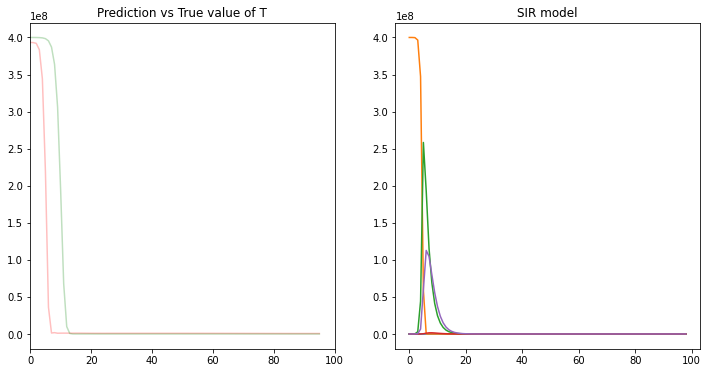

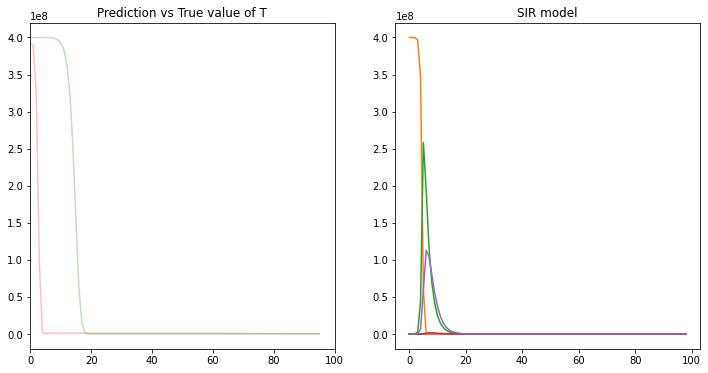

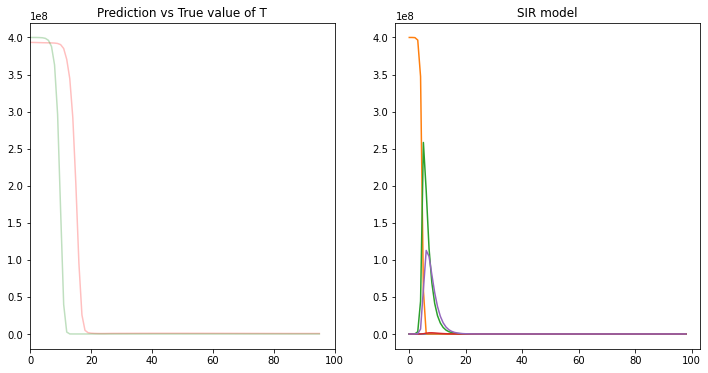

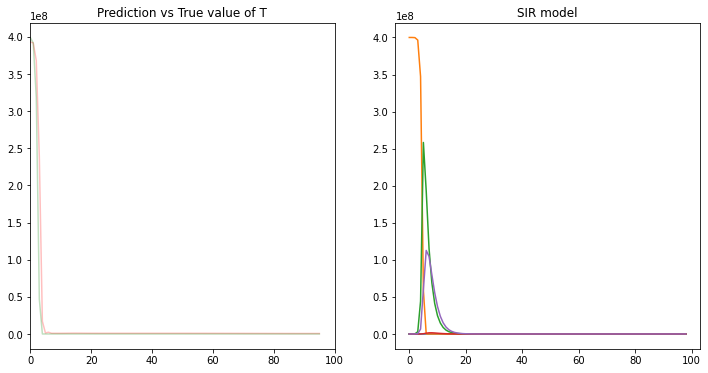

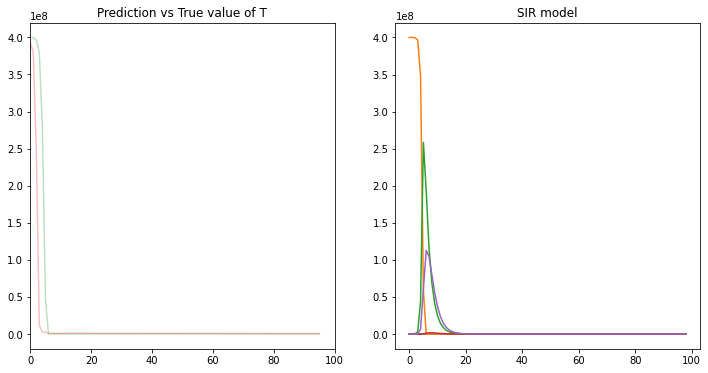

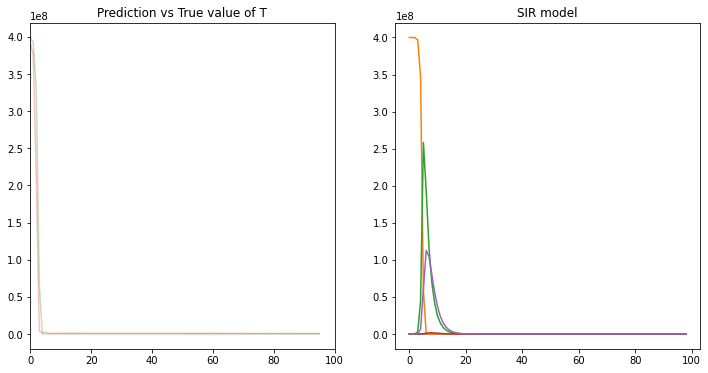

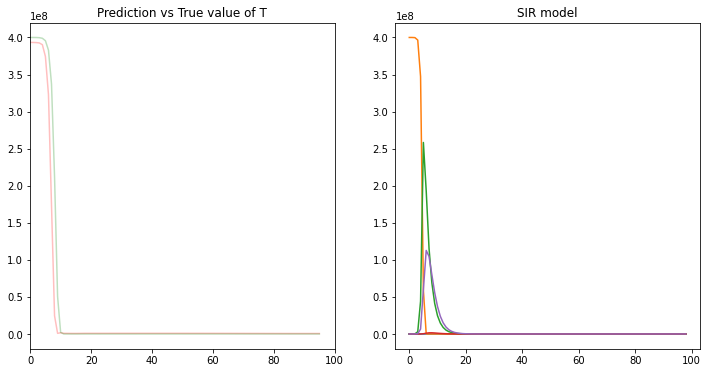

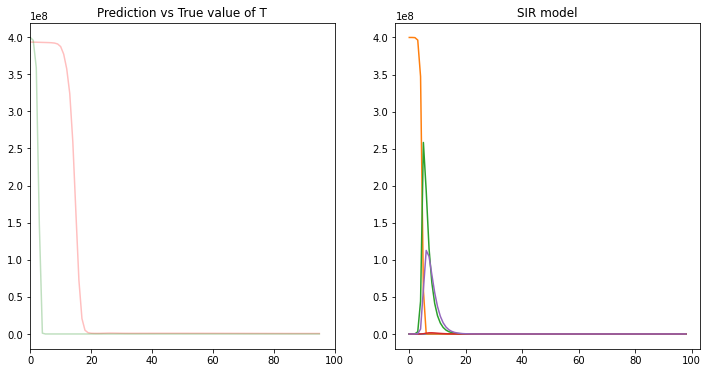

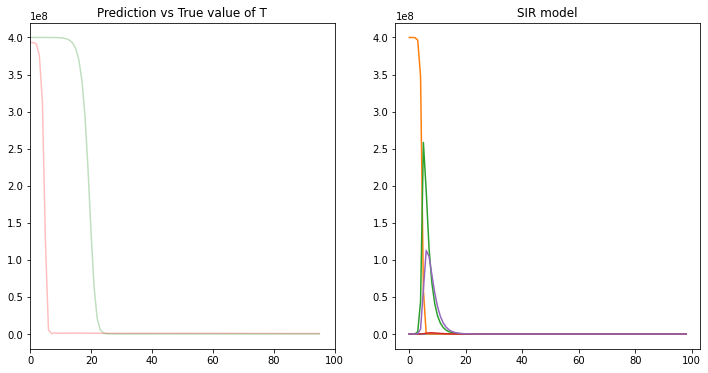

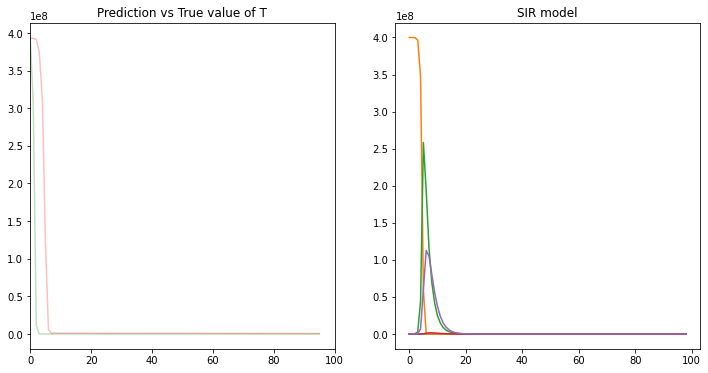

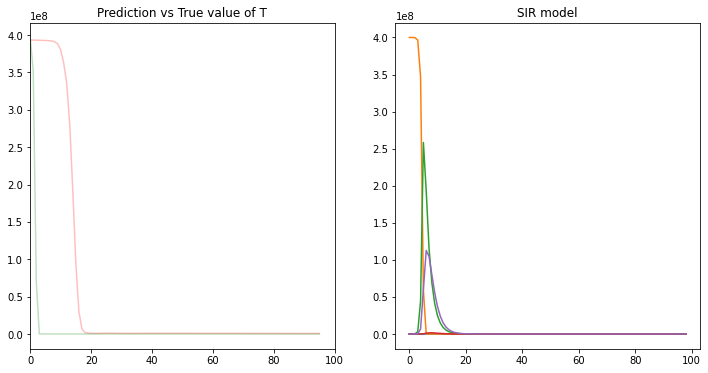

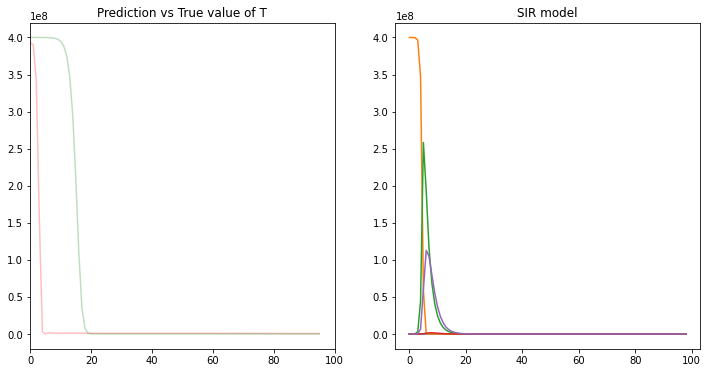

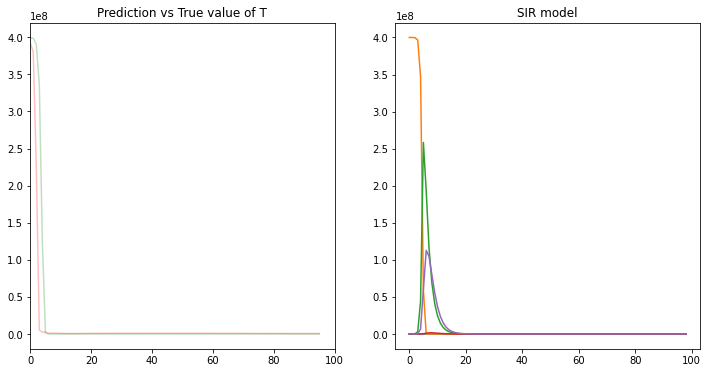

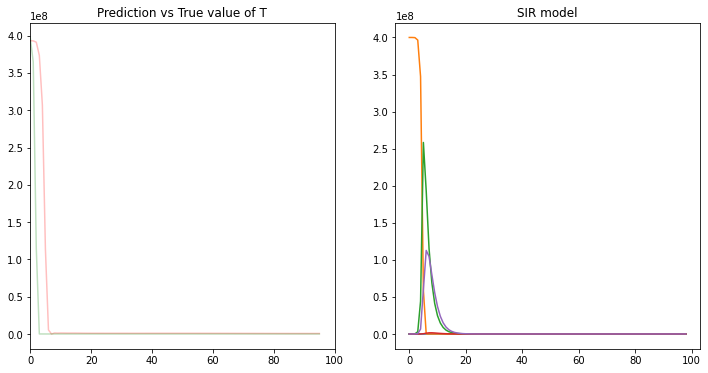

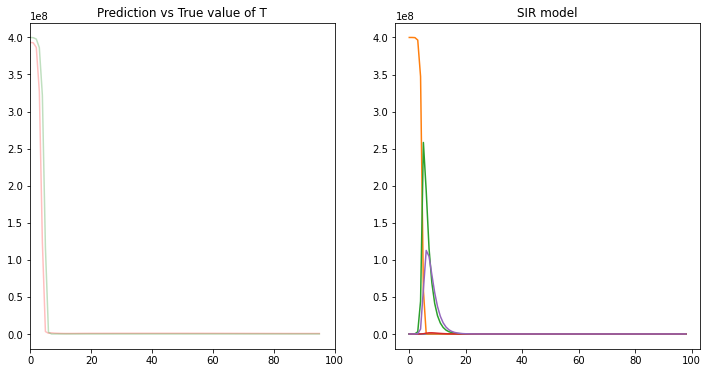

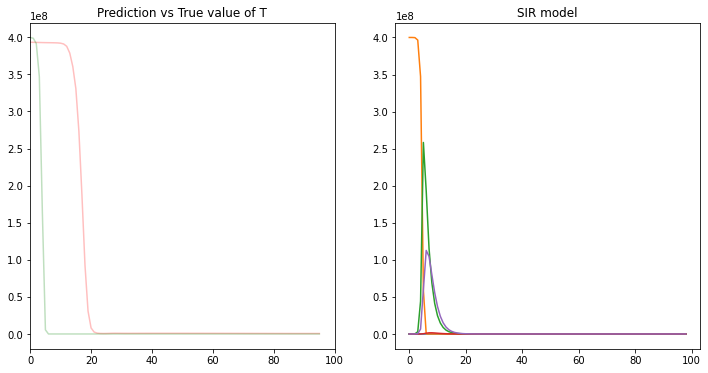

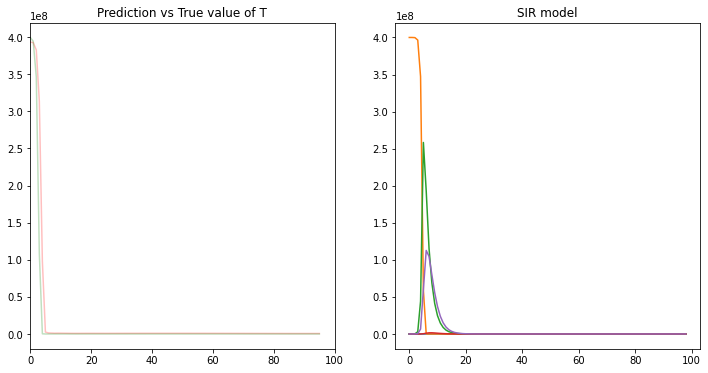

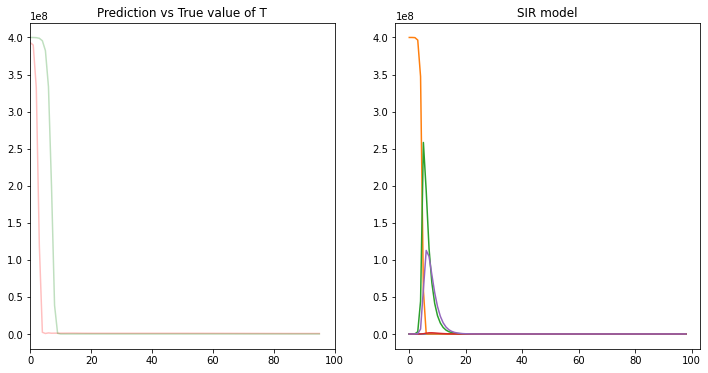

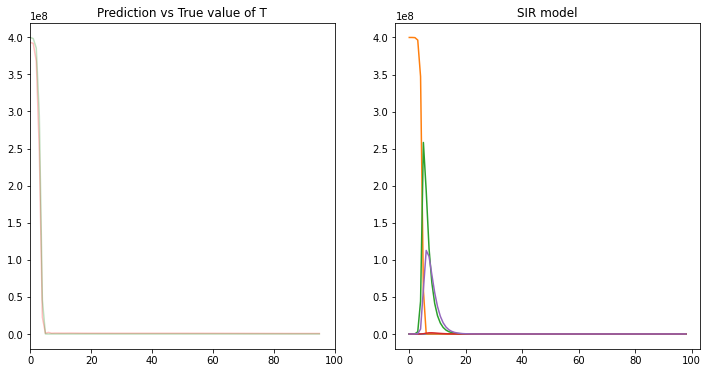

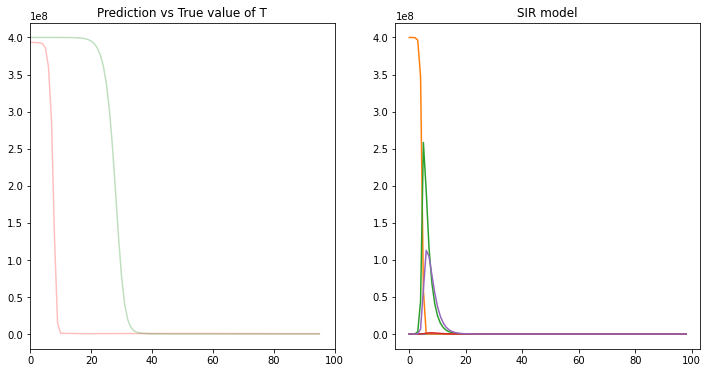

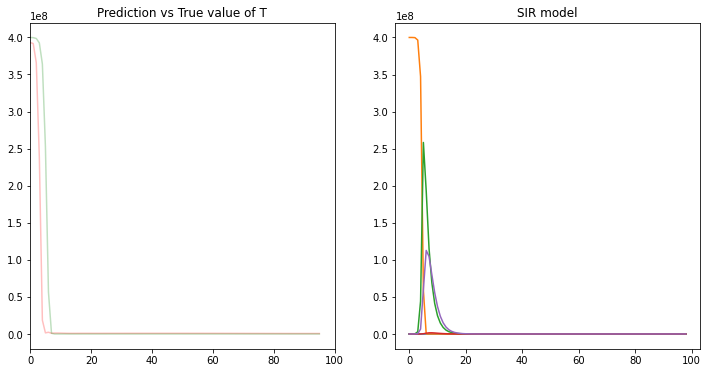

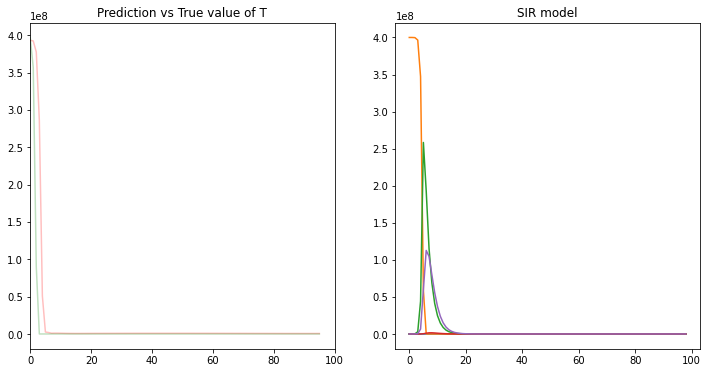

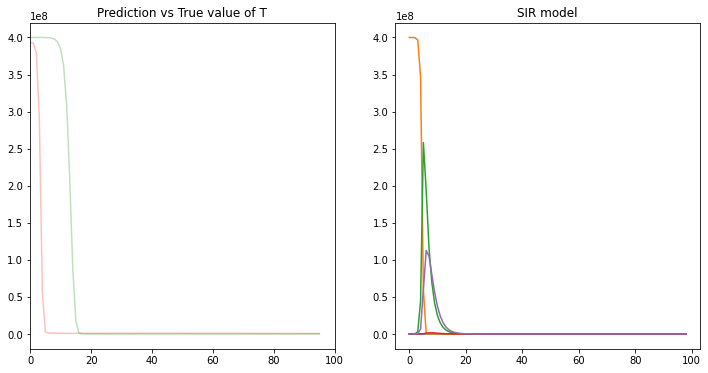

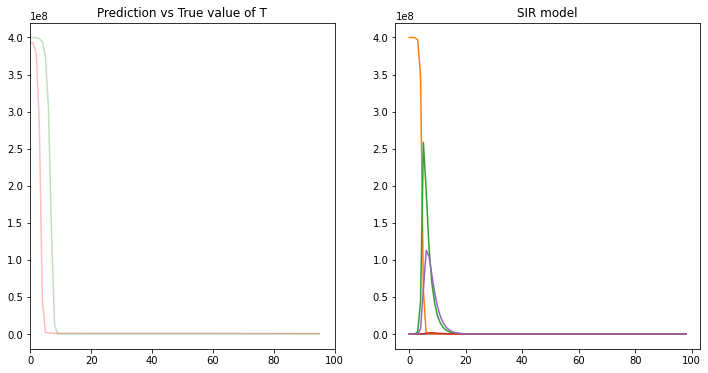

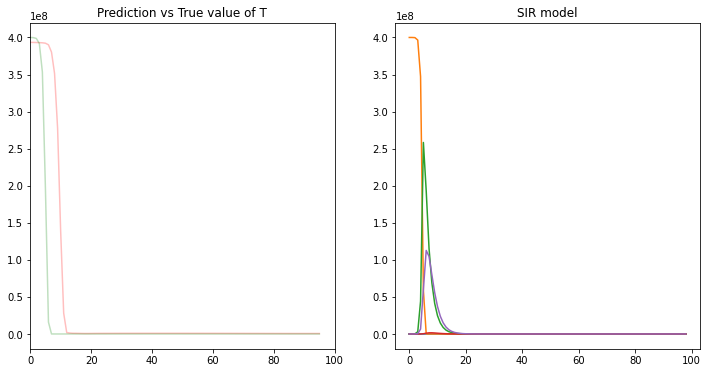

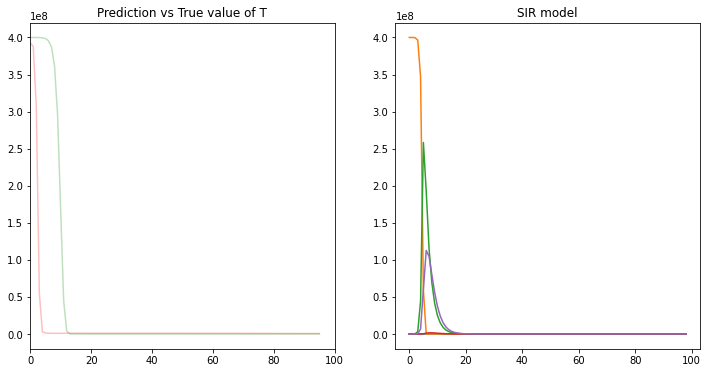

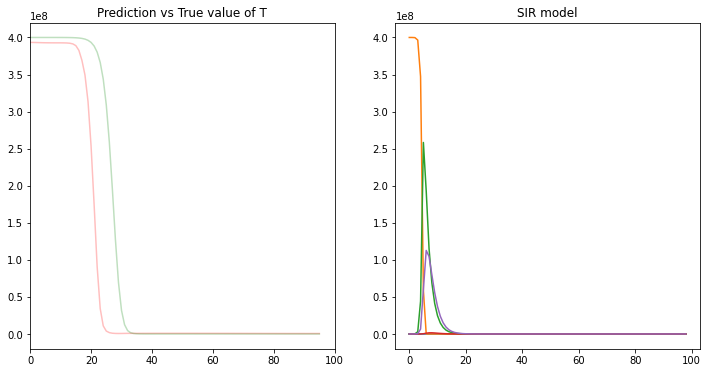

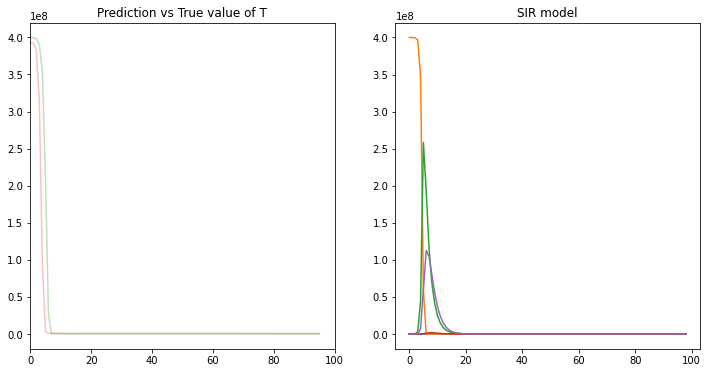

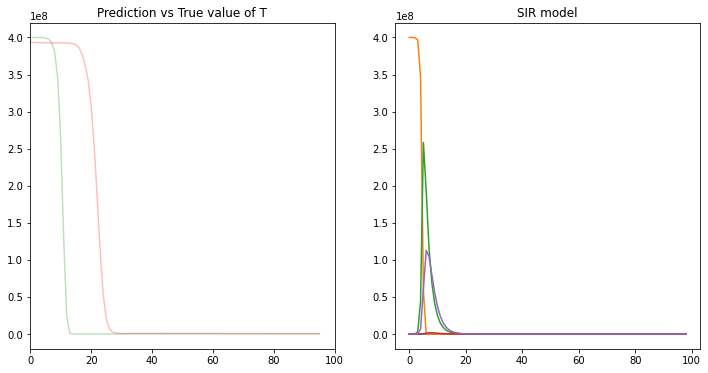

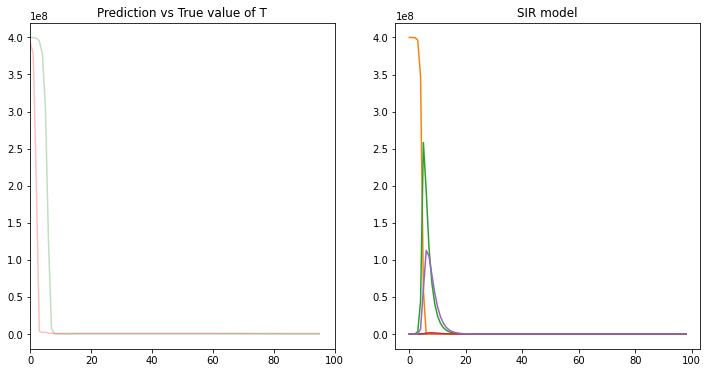

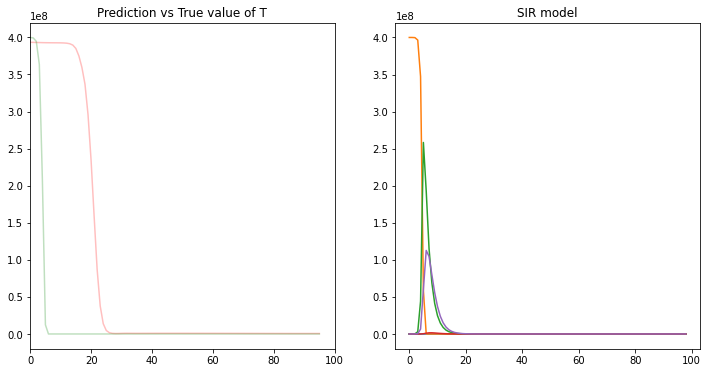

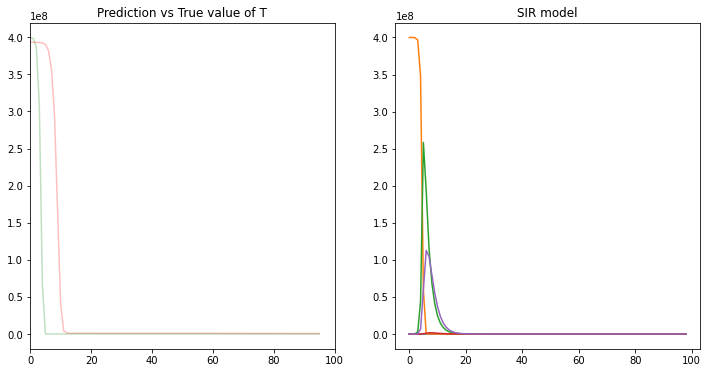

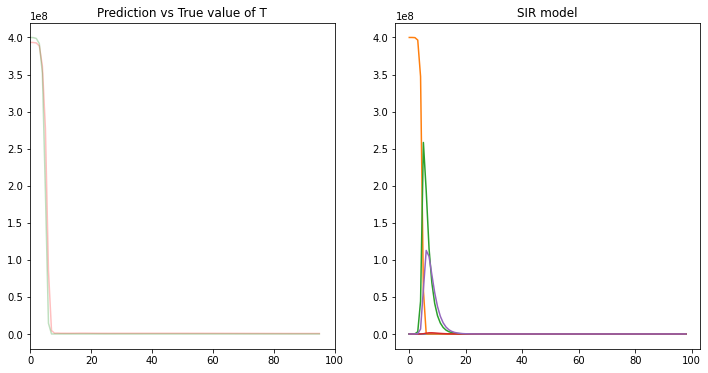

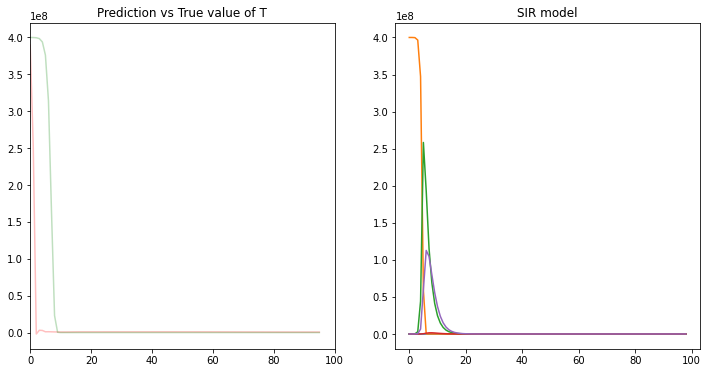

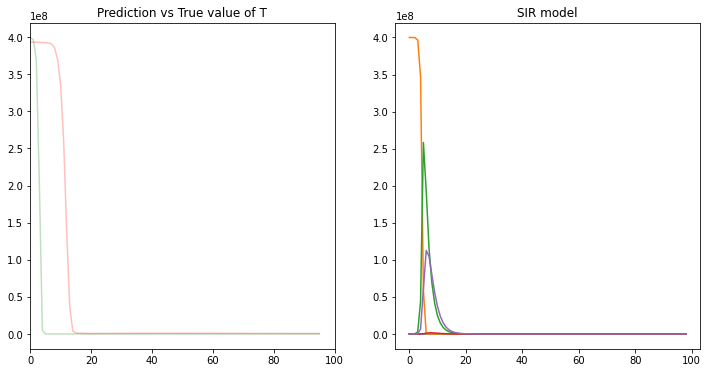

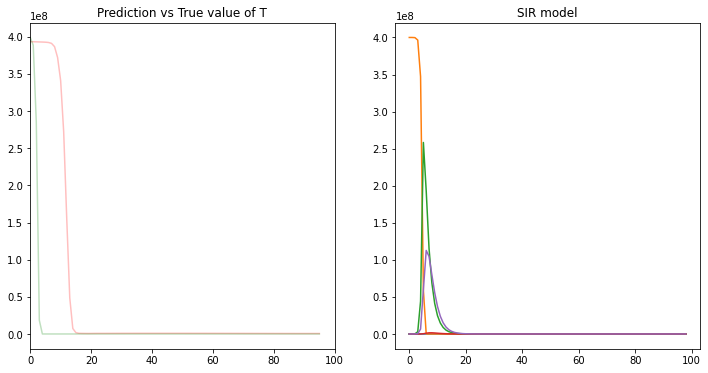

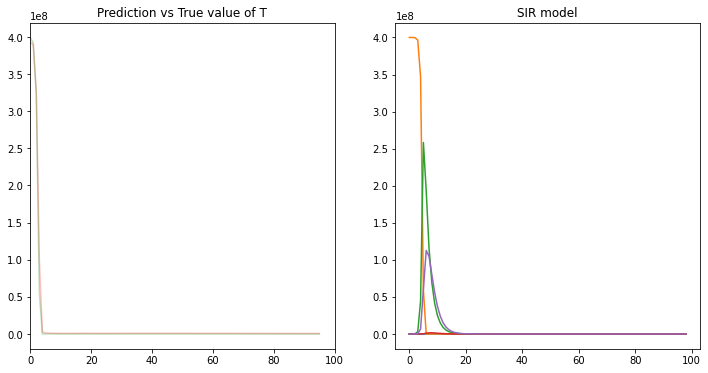

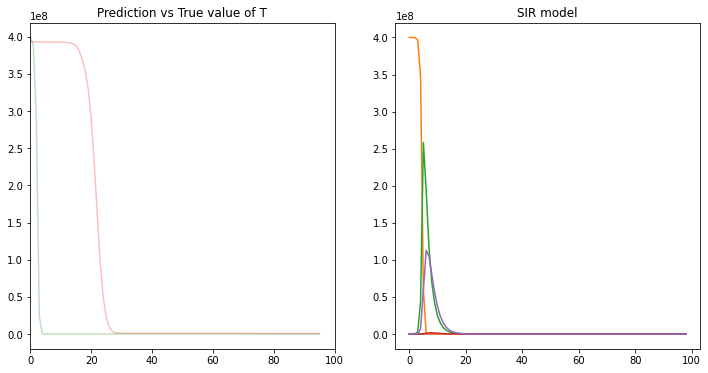

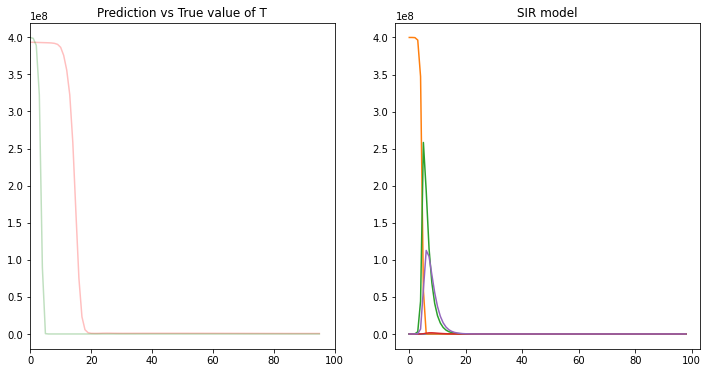

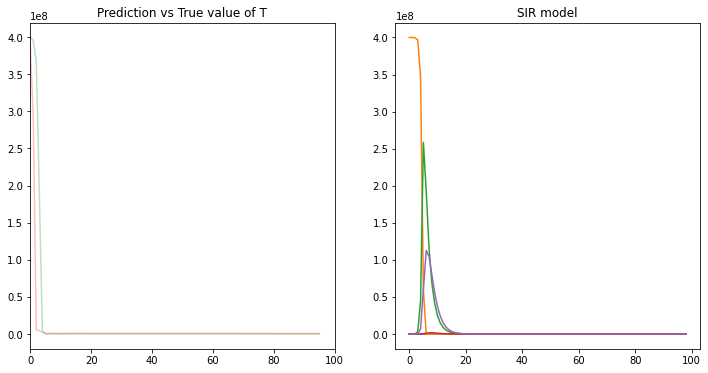

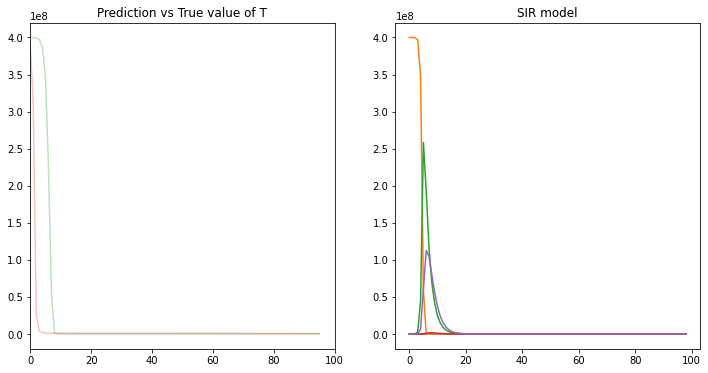

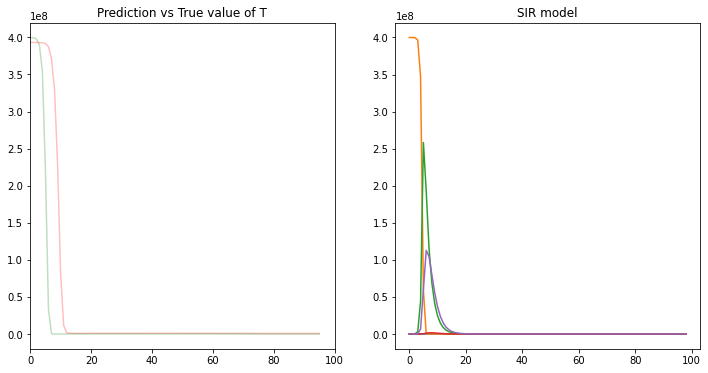

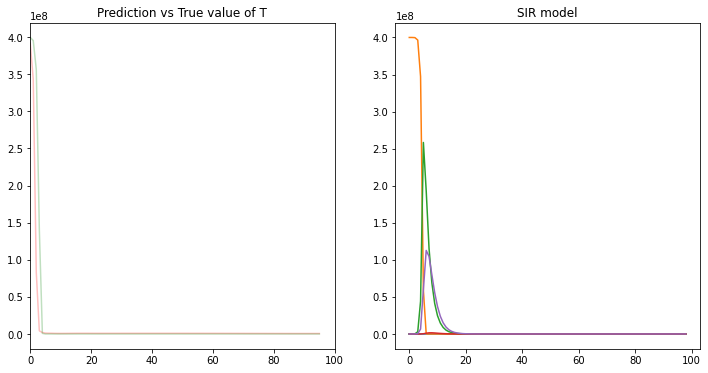

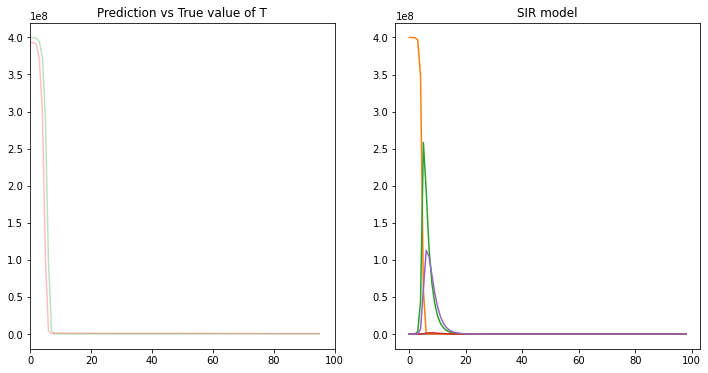

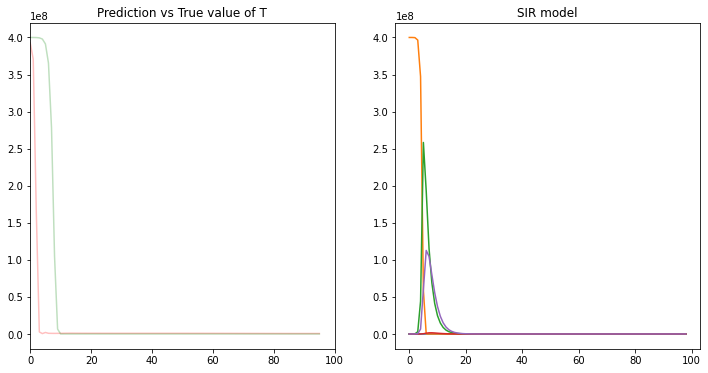

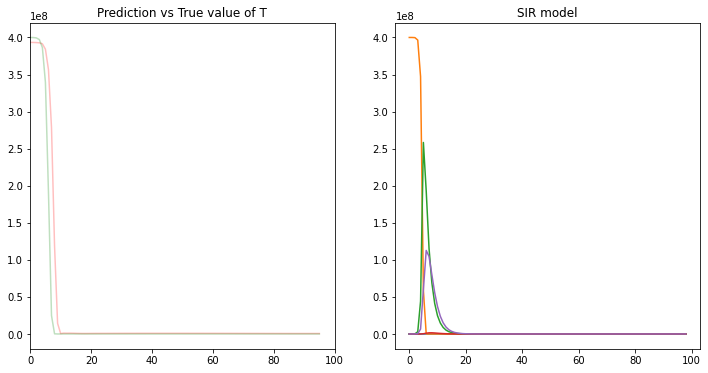

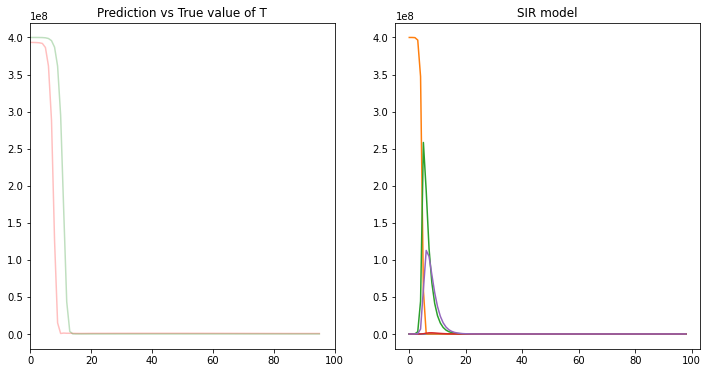

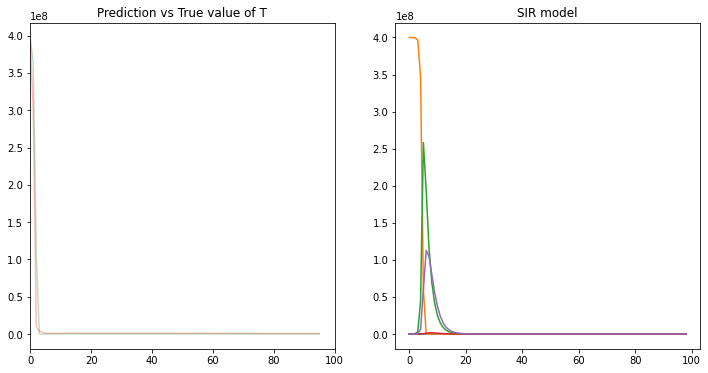

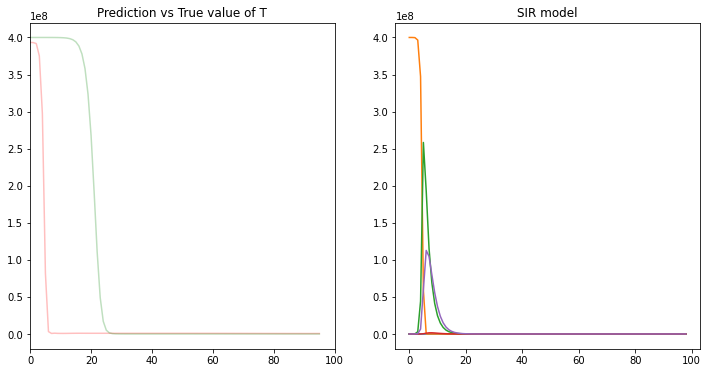

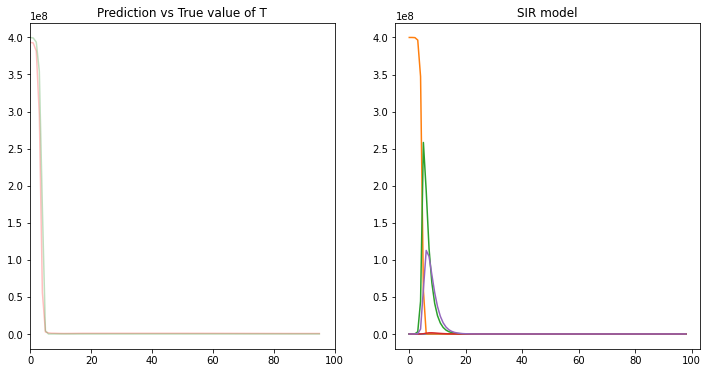

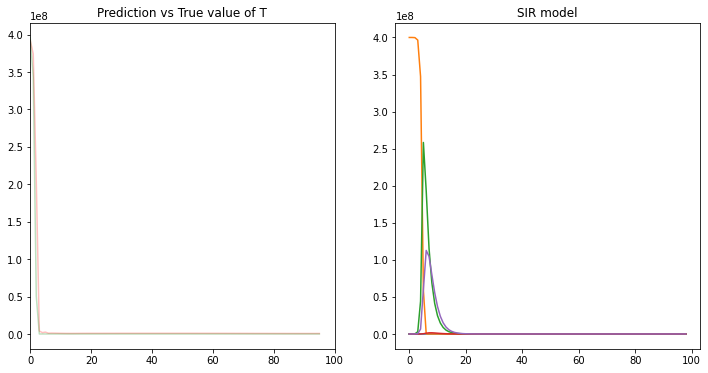

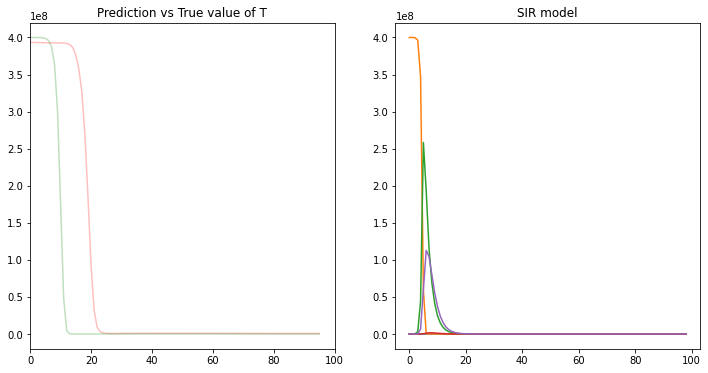

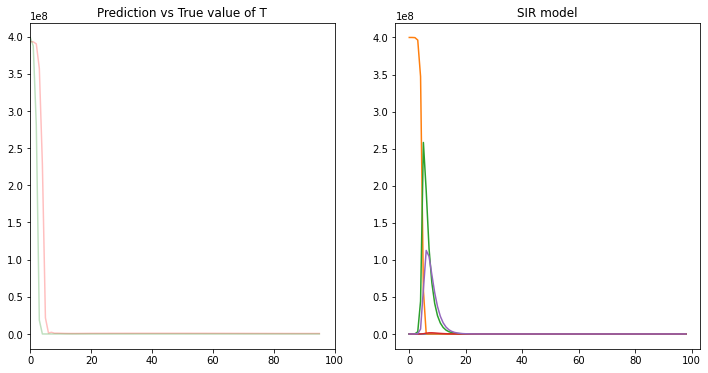

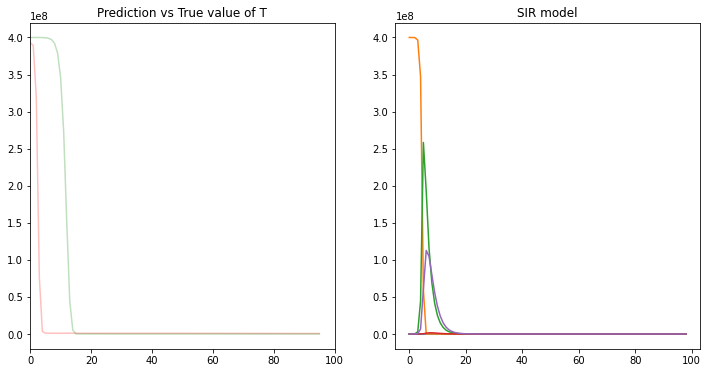

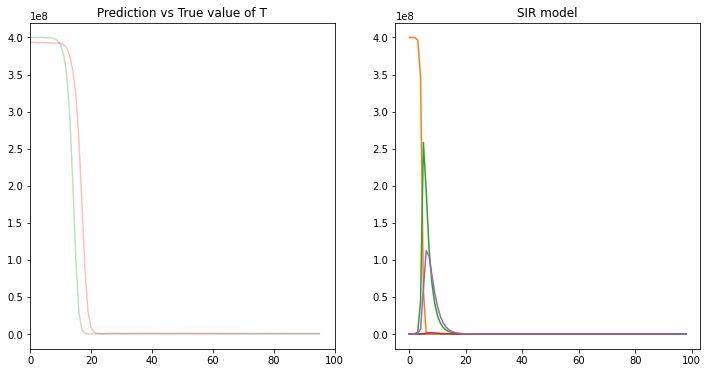

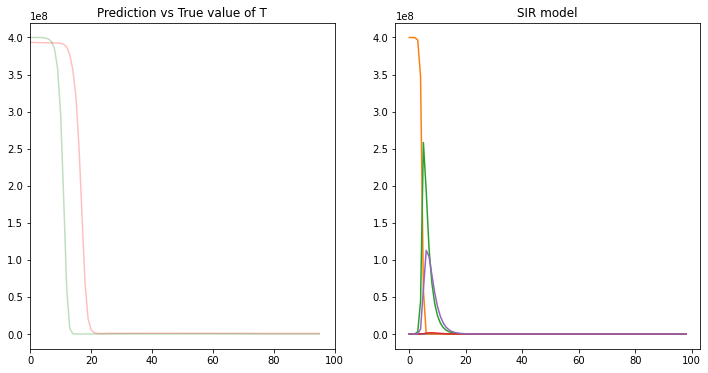

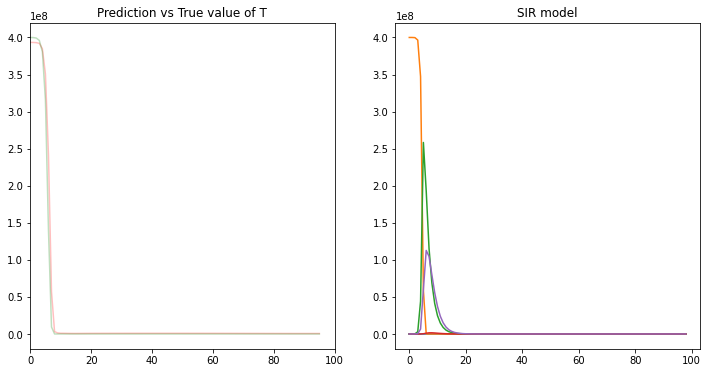

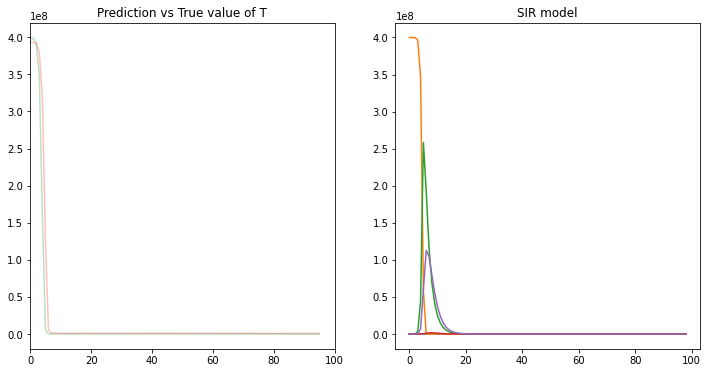

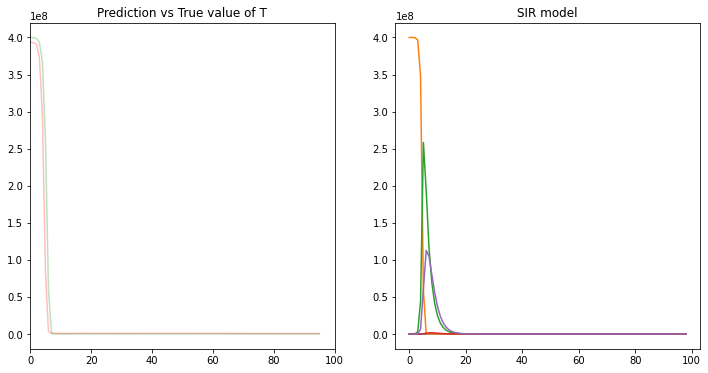

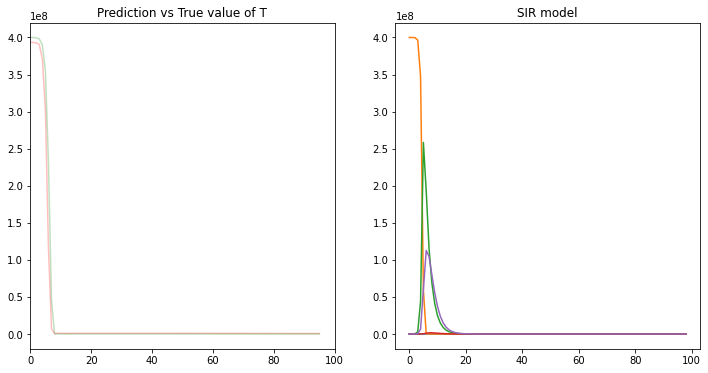

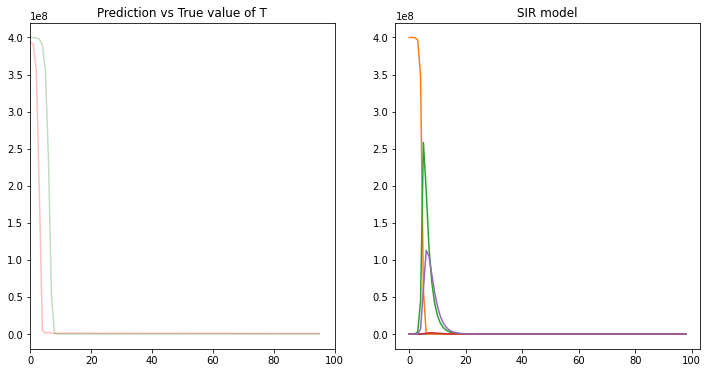

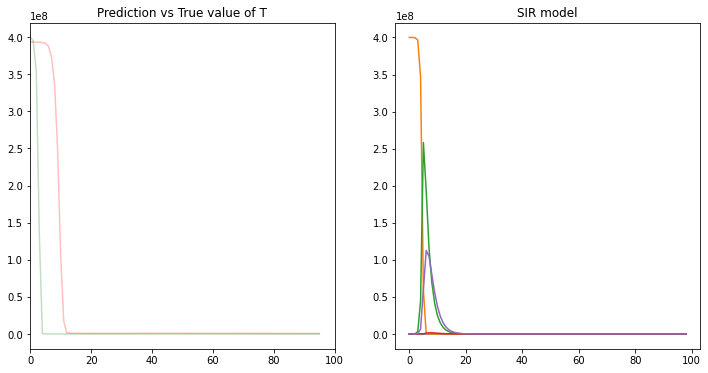

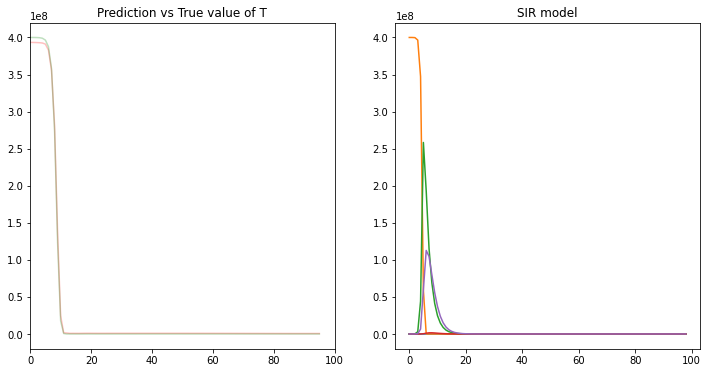

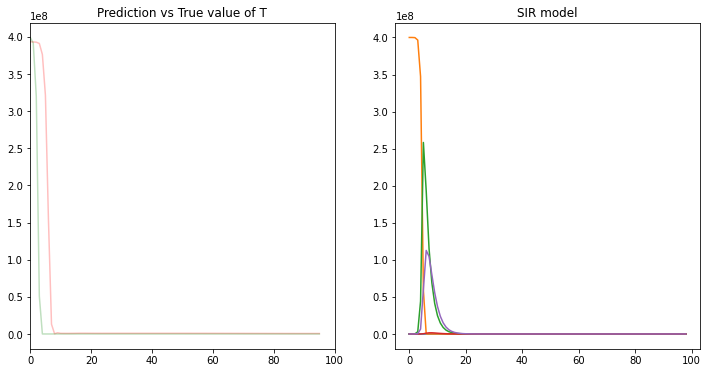

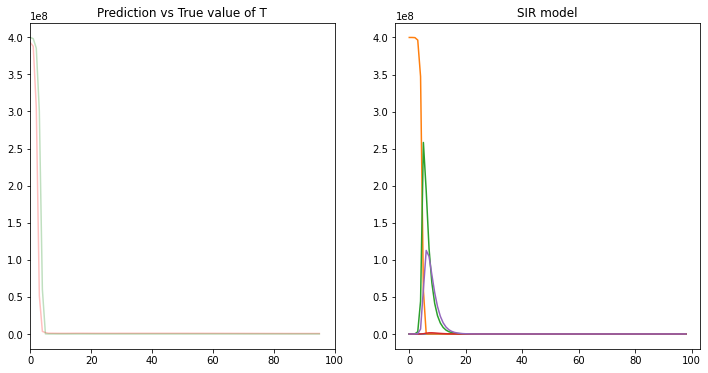

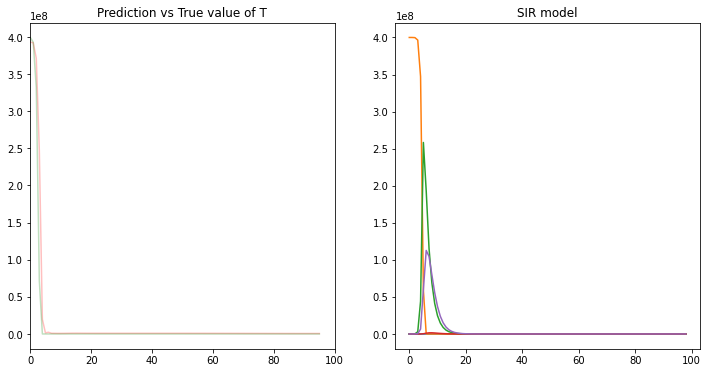

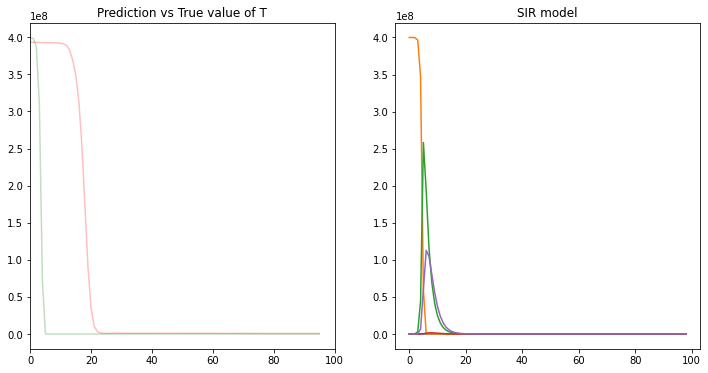

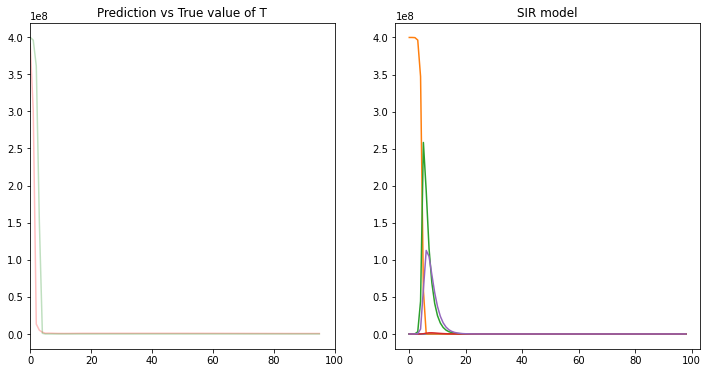

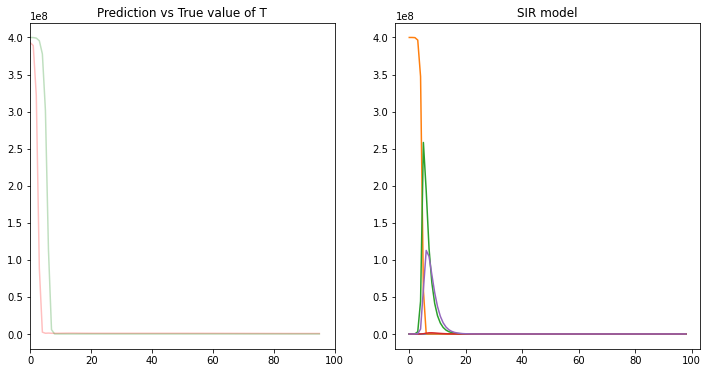

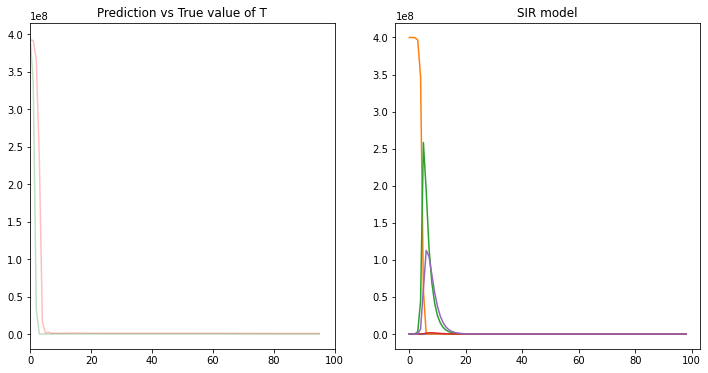

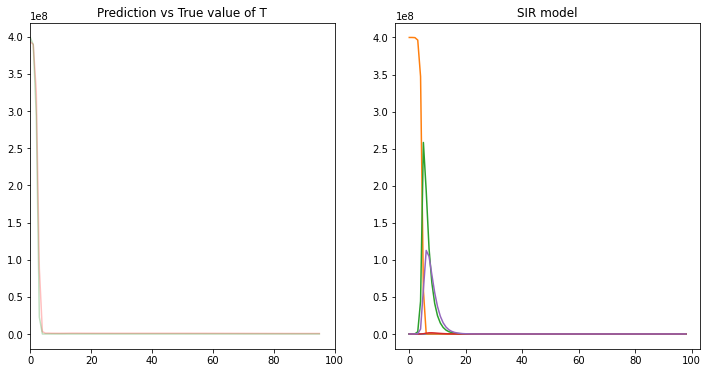

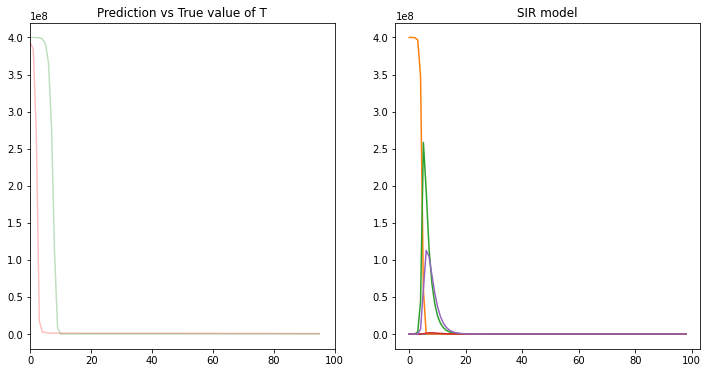

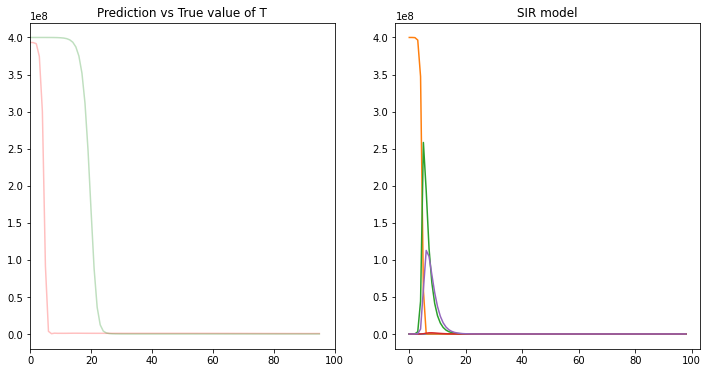

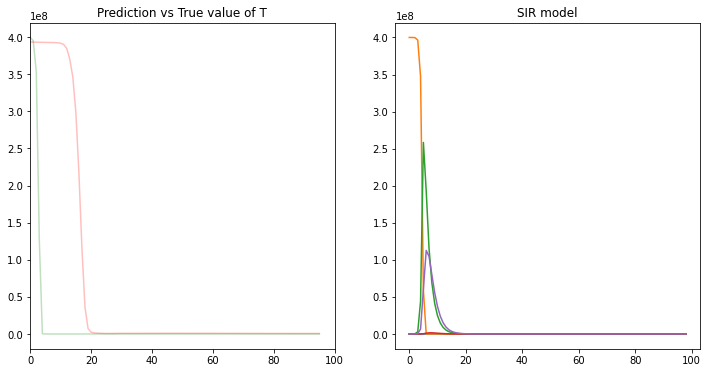

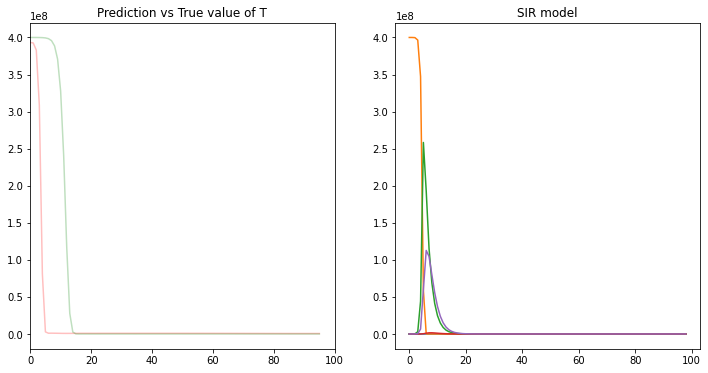

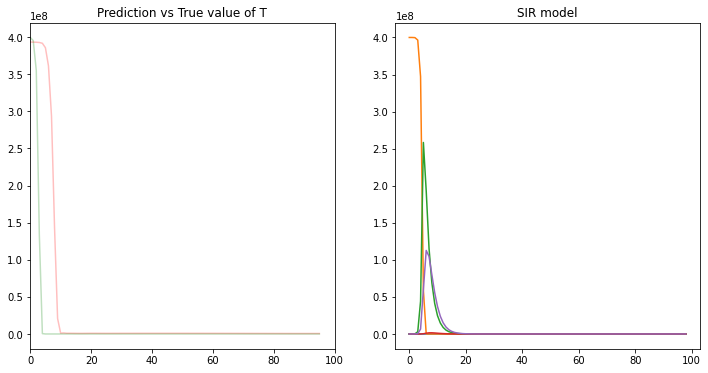

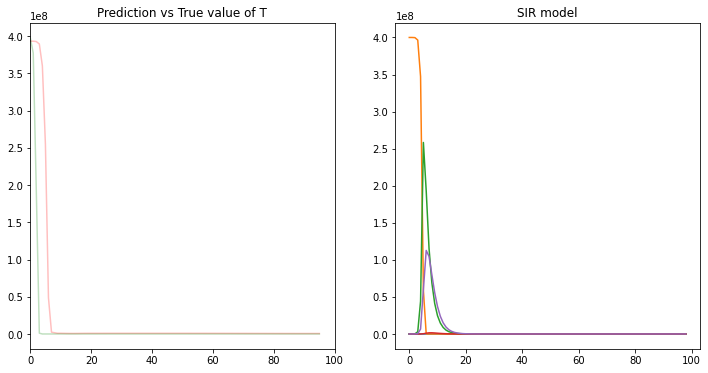

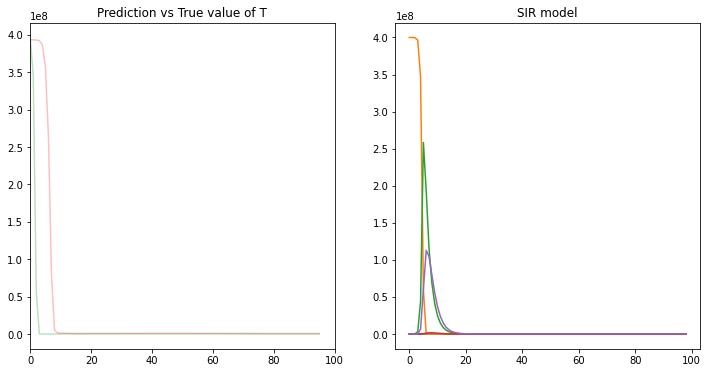

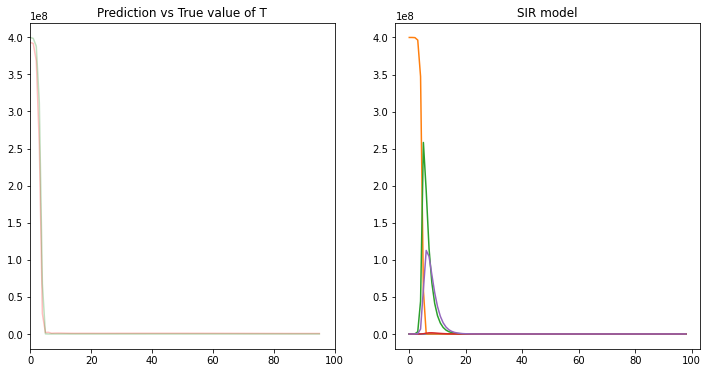

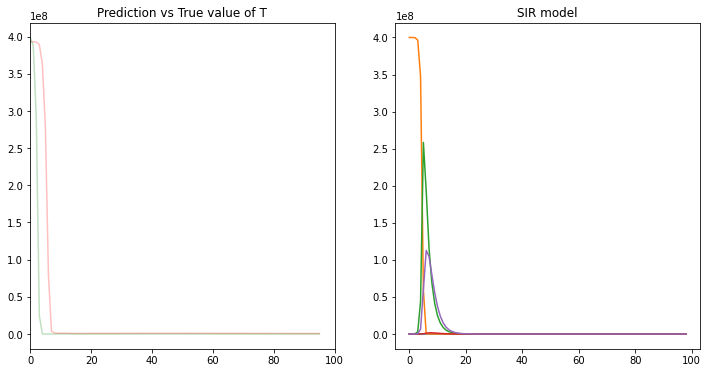

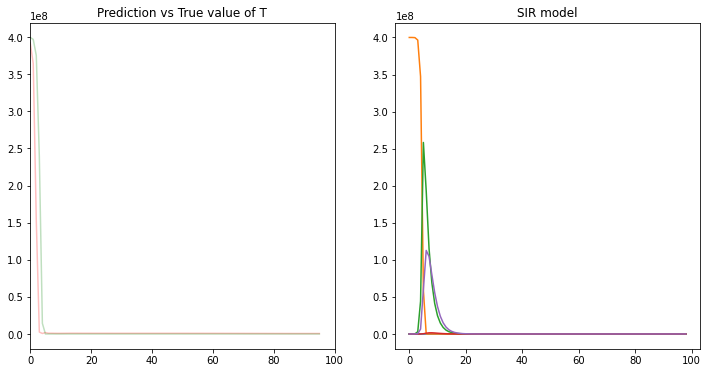

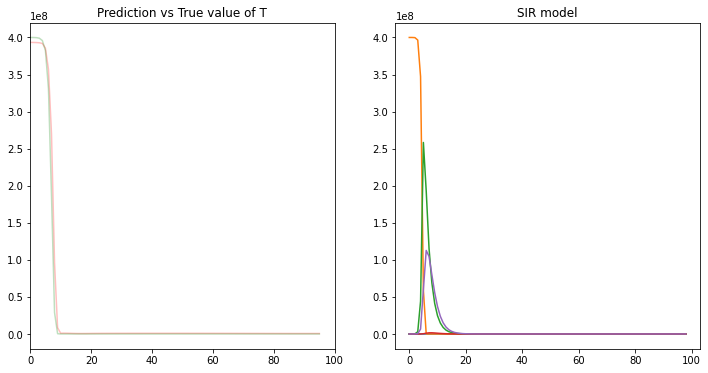

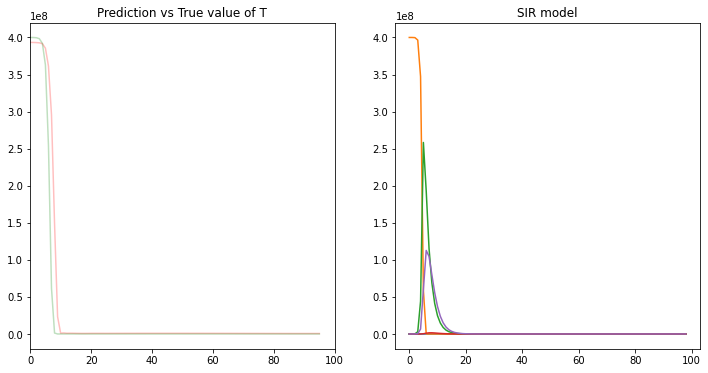

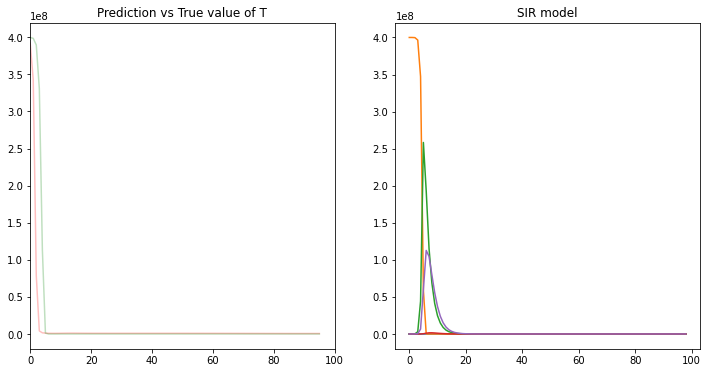

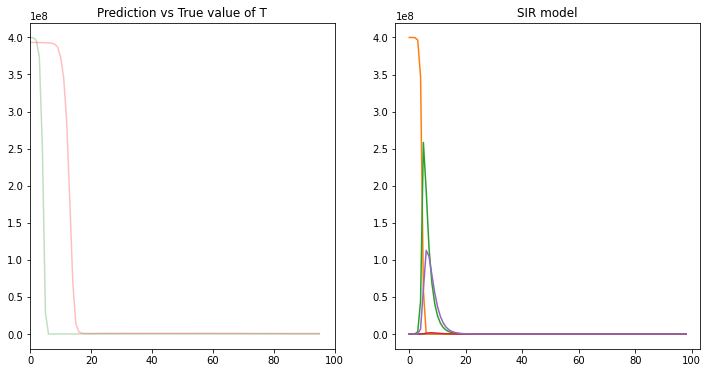

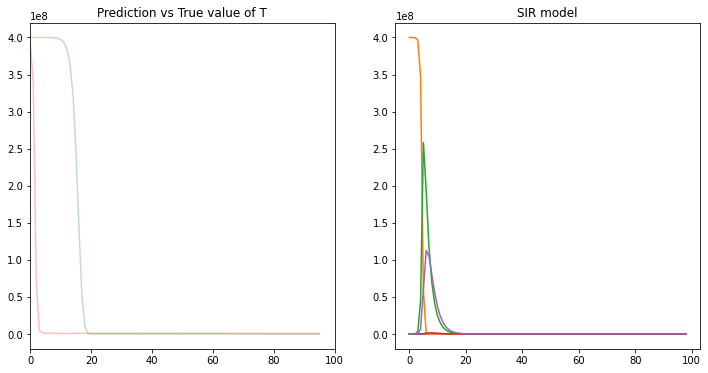

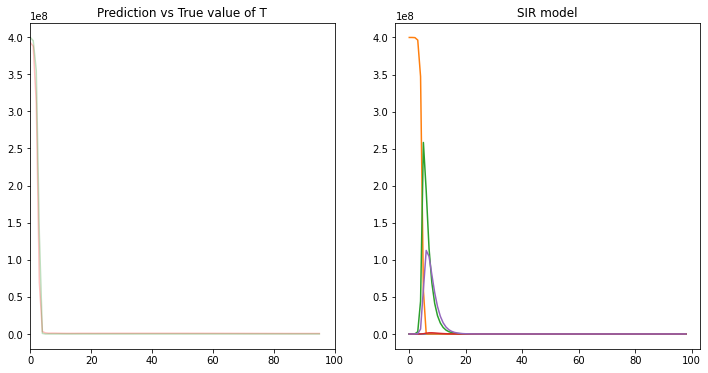

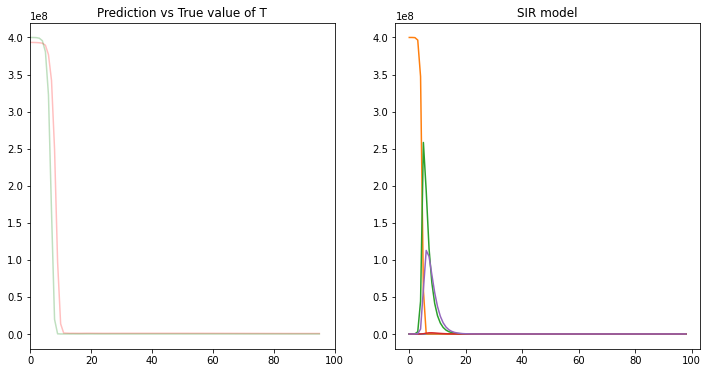

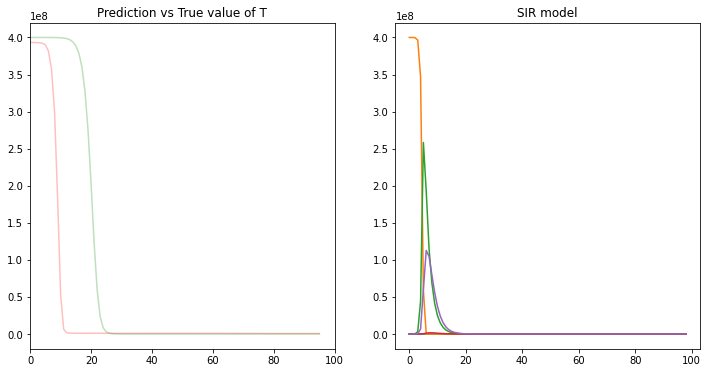

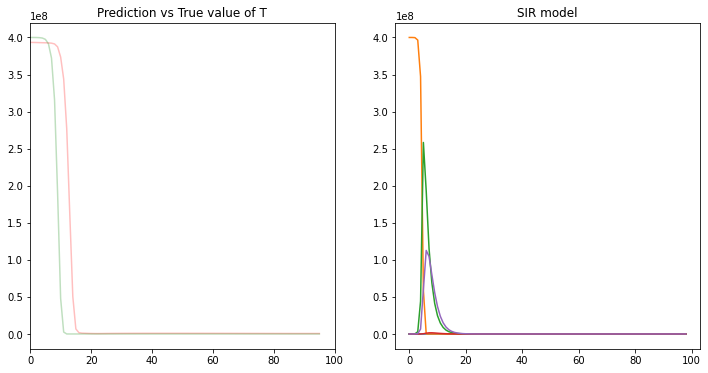

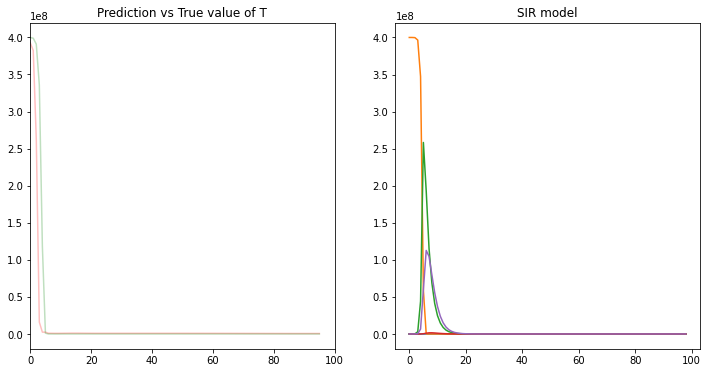

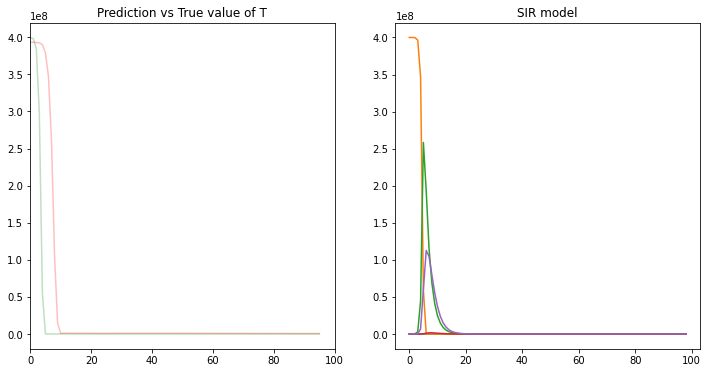

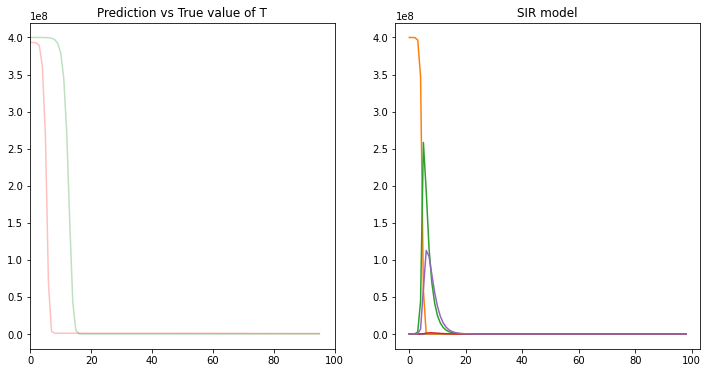

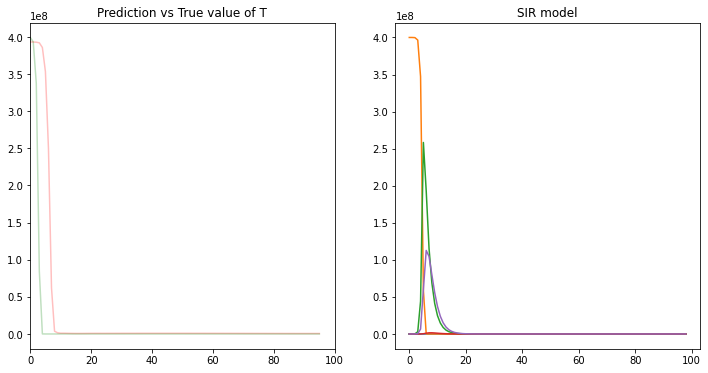

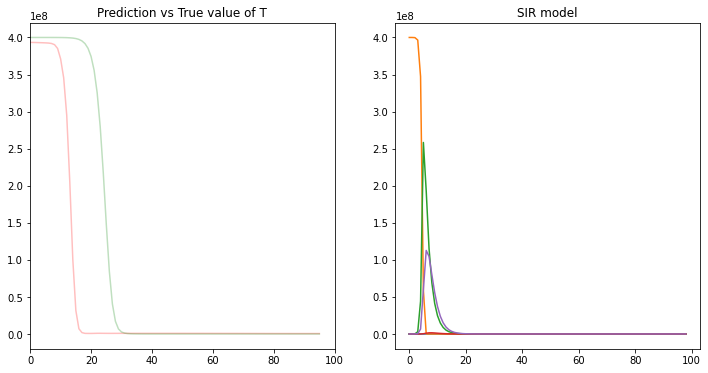

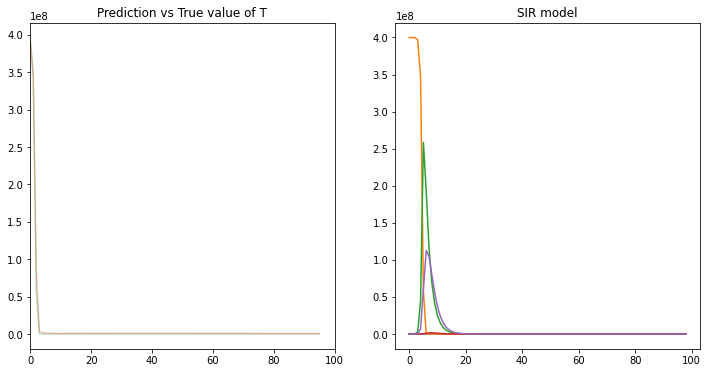

In [78]:
import matplotlib.pyplot as plt
import numpy as np

overlapping = 0.25
for x in range(100):

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax.set_xlim([0, 100])
    ax.set_title("Prediction vs True value of T")
    ax.plot(fin_values[x],c='red', alpha=overlapping)
    ax.plot(original_vals[x],c='green', alpha=overlapping)
    ax.set_xlim([0, 100])
    ax2.set_title("SIR model")
    plt.plot(batches_of_TestX[i][:99])
    plt.show()